In [1]:
import pandas as pd
import numpy as np

In [ ]:
column_names = (
    ['Time'] + 
    ['Setpoint_Gas1', 'Setpoint_Gas2'] + 
    [f'Sensor_{i:02d}' for i in range(1, 17)]
)
df_ethylene_co = pd.read_csv(
    'datasets/ethylene_CO.txt',
    sep='\s+',
    header=None,
    names=column_names,
    engine='python'
)

df_ethylene_co.rename(columns={
    'Setpoint_Gas1': 'CO_ppm',
    'Setpoint_Gas2': 'Ethylene_ppm'
}, inplace=True)

print(f"Dataset CO cargado: {df_ethylene_co.shape}")

df_ethylene_methane = pd.read_csv(
    'datasets/ethylene_methane.txt',
    sep='\s+',
    header=None,
    names=column_names,
    engine='python'
)

df_ethylene_methane.rename(columns={
    'Setpoint_Gas1': 'Methane_ppm',
    'Setpoint_Gas2': 'Ethylene_ppm'
}, inplace=True)

print(f"Dataset Methane cargado: {df_ethylene_methane.shape}")

In [ ]:
df_ethylene_methane=df_ethylene_methane.drop(0)
df_ethylene_co=df_ethylene_co.drop(0)
df_ethylene_co.to_csv('datasets/ethylene_CO.csv', index=False)
df_ethylene_methane.to_csv('datasets/ethylene_methane.csv', index=False)

print("CSVs creados correctamente")

CSVs creados correctamente


In [2]:
df_ethylene_co=pd.read_csv("datasets/ethylene_CO.csv")
df_ethylene_methane=pd.read_csv("datasets/ethylene_methane.csv")

In [3]:
df_ethylene_co.head(5)

,Time,CO_ppm,Ethylene_ppm,Sensor_01,Sensor_02,Sensor_03,Sensor_04,Sensor_05,Sensor_06,Sensor_07,Sensor_08,Sensor_09,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16
0,0.00,0.0,0.0,-50.85,-1.95,-41.82,1.30,-4.07,-28.73,-13.49,-3.25,55139.95,50669.50,9626.26,9762.62,24544.02,21420.68,7650.61,6928.42
1,0.01,0.0,0.0,-49.40,-5.53,-42.78,0.49,3.58,-34.55,-9.59,5.37,54395.77,50046.91,9433.20,9591.21,24137.13,20930.33,7498.79,6800.66
2,0.01,0.0,0.0,-40.04,-16.09,-27.59,0.00,-7.16,-42.14,-12.52,-5.86,53960.02,49299.30,9324.40,9449.81,23628.90,20504.94,7369.67,6697.47
3,0.03,0.0,0.0,-47.14,-10.57,-32.28,4.40,-11.22,-37.94,-7.16,-1.14,53047.71,48907.00,9170.64,9305.58,23101.66,20101.42,7285.13,6578.52
4,0.04,0.0,0.0,-33.58,-20.79,-33.25,6.03,3.42,-34.22,-14.46,8.31,52700.28,48330.96,9073.64,9163.47,22689.54,19694.07,7156.74,6468.32


In [4]:
print("VERIFICACIÓN DE ESTRUCTURA")
print("ETHYLENE + CO")
print(f"  Shape: {df_ethylene_co.shape}")
print(f"  Columnas esperadas: 19, Encontradas: {df_ethylene_co.shape[1]}")
print(f"  Filas: {df_ethylene_co.shape[0]:,}")

print("ETHYLENE + METHANE")
print(f"  Shape: {df_ethylene_methane.shape}")
print(f"  Columnas esperadas: 19, Encontradas: {df_ethylene_methane.shape[1]}")
print(f"  Filas: {df_ethylene_methane.shape[0]:,}")

print("Columnas:")
print(df_ethylene_co.columns.tolist())

VERIFICACIÓN DE ESTRUCTURA
ETHYLENE + CO
  Shape: (4208261, 19)
  Columnas esperadas: 19, Encontradas: 19
  Filas: 4,208,261
ETHYLENE + METHANE
  Shape: (4178504, 19)
  Columnas esperadas: 19, Encontradas: 19
  Filas: 4,178,504
Columnas:
['Time', 'CO_ppm', 'Ethylene_ppm', 'Sensor_01', 'Sensor_02', 'Sensor_03', 'Sensor_04', 'Sensor_05', 'Sensor_06', 'Sensor_07', 'Sensor_08', 'Sensor_09', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16']


In [5]:
# Celda: Convertir columna Time a numérico
df_ethylene_co['Time'] = pd.to_numeric(df_ethylene_co['Time'], errors='coerce')
df_ethylene_methane['Time'] = pd.to_numeric(df_ethylene_methane['Time'], errors='coerce')

print("✓ Columna Time convertida a numérico")
print(f"Tipo de dato Time (CO): {df_ethylene_co['Time'].dtype}")
print(f"Tipo de dato Time (Methane): {df_ethylene_methane['Time'].dtype}")

✓ Columna Time convertida a numérico
Tipo de dato Time (CO): float64
Tipo de dato Time (Methane): float64


In [6]:
# Celda 7: Verificación de continuidad temporal
print("=" * 70)
print("VERIFICACIÓN DE CONTINUIDAD TEMPORAL")
print("=" * 70)

def check_temporal_continuity(df, name):
    print(f"\n📊 {name}")
    
    # Calcular diferencias de tiempo
    time_diff = df['Time'].diff()
    
    # Frecuencia esperada: 100 Hz = 0.01 segundos
    expected_interval = 0.01
    
    print(f"  Tiempo inicial: {df['Time'].iloc[0]:.2f} s")
    print(f"  Tiempo final: {df['Time'].iloc[-1]:.2f} s")
    print(f"  Duración total: {(df['Time'].iloc[-1] - df['Time'].iloc[0]) / 3600:.2f} horas")
    
    print(f"\n  Intervalo esperado: {expected_interval} s (100 Hz)")
    print(f"  Intervalo promedio: {time_diff.mean():.6f} s")
    print(f"  Intervalo mínimo: {time_diff.min():.6f} s")
    print(f"  Intervalo máximo: {time_diff.max():.6f} s")
    
    # Detectar saltos temporales
    tolerance = 0.001  # 1 ms de tolerancia
    gaps = time_diff[(time_diff > expected_interval + tolerance) | 
                     (time_diff < expected_interval - tolerance)]
    
    if len(gaps) > 0:
        print(f"\n  ⚠ Se encontraron {len(gaps)} discontinuidades temporales")
        print(f"  Primeras 5 discontinuidades:")
        print(gaps.head())
    else:
        print(f"\n  ✓ Continuidad temporal perfecta")

check_temporal_continuity(df_ethylene_co, "ETHYLENE + CO")
check_temporal_continuity(df_ethylene_methane, "ETHYLENE + METHANE")

VERIFICACIÓN DE CONTINUIDAD TEMPORAL

📊 ETHYLENE + CO
  Tiempo inicial: 0.00 s
  Tiempo final: 42087.55 s
  Duración total: 11.69 horas

  Intervalo esperado: 0.01 s (100 Hz)
  Intervalo promedio: 0.010001 s
  Intervalo mínimo: 0.000000 s
  Intervalo máximo: 0.380000 s

  ⚠ Se encontraron 245425 discontinuidades temporales
  Primeras 5 discontinuidades:
2     0.00
3     0.02
8     0.00
9     0.02
11    0.00
Name: Time, dtype: float64

📊 ETHYLENE + METHANE
  Tiempo inicial: 0.00 s
  Tiempo final: 41790.19 s
  Duración total: 11.61 horas

  Intervalo esperado: 0.01 s (100 Hz)
  Intervalo promedio: 0.010001 s
  Intervalo mínimo: 0.000000 s
  Intervalo máximo: 0.270000 s

  ⚠ Se encontraron 209949 discontinuidades temporales
  Primeras 5 discontinuidades:
2511    0.02
2512    0.00
5791    0.02
6481    0.02
6482    0.00
Name: Time, dtype: float64


In [7]:
# Celda 8: Verificación de valores faltantes
print("=" * 70)
print("VERIFICACIÓN DE VALORES FALTANTES")
print("=" * 70)

def check_missing_values(df, name):
    print(f"\n📊 {name}")
    missing = df.isnull().sum()
    
    if missing.sum() == 0:
        print("  ✓ No hay valores faltantes")
    else:
        print(f"  ⚠ Total de valores faltantes: {missing.sum()}")
        print("\n  Desglose por columna:")
        print(missing[missing > 0])

check_missing_values(df_ethylene_co, "ETHYLENE + CO")
check_missing_values(df_ethylene_methane, "ETHYLENE + METHANE")

VERIFICACIÓN DE VALORES FALTANTES

📊 ETHYLENE + CO
  ✓ No hay valores faltantes

📊 ETHYLENE + METHANE
  ✓ No hay valores faltantes


In [8]:
# Celda 9: Detección de señales planas (flatlines)
print("=" * 70)
print("DETECCIÓN DE SEÑALES PLANAS (FLATLINES)")
print("=" * 70)

def detect_flatlines(df, name, window=1000):
    """Detecta segmentos donde el sensor no varía"""
    print(f"\n📊 {name}")
    
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]
    
    flatlines_found = False
    
    for sensor in sensor_cols:
        # Calcular desviación estándar en ventanas deslizantes
        rolling_std = df[sensor].rolling(window=window).std()
        
        # Detectar ventanas con std muy baja (señal plana)
        flat_segments = rolling_std[rolling_std < 0.01].index
        
        if len(flat_segments) > window:  # Solo reportar si hay suficientes puntos
            print(f"  ⚠ {sensor}: {len(flat_segments)} puntos planos detectados")
            flatlines_found = True
    
    if not flatlines_found:
        print("  ✓ No se detectaron señales planas significativas")

detect_flatlines(df_ethylene_co, "ETHYLENE + CO")
detect_flatlines(df_ethylene_methane, "ETHYLENE + METHANE")

DETECCIÓN DE SEÑALES PLANAS (FLATLINES)

📊 ETHYLENE + CO


  ✓ No se detectaron señales planas significativas

📊 ETHYLENE + METHANE
  ✓ No se detectaron señales planas significativas


In [9]:
# Celda 10: Detección de saturación
print("=" * 70)
print("DETECCIÓN DE SATURACIÓN EN SENSORES")
print("=" * 70)

def detect_saturation(df, name, percentile=99.9):
    """Detecta si los sensores alcanzan valores de saturación"""
    print(f"\n📊 {name}")
    
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]
    
    saturation_found = False
    
    for sensor in sensor_cols:
        max_val = df[sensor].max()
        threshold = df[sensor].quantile(percentile / 100)
        
        # Contar cuántos valores están en el percentil 99.9
        saturated = (df[sensor] >= threshold).sum()
        pct_saturated = (saturated / len(df)) * 100
        
        if pct_saturated > 1.0:  # Más del 1% saturado
            print(f"  ⚠ {sensor}: {pct_saturated:.2f}% valores saturados (>{threshold:.2f})")
            saturation_found = True
    
    if not saturation_found:
        print("  ✓ No se detectó saturación significativa")

detect_saturation(df_ethylene_co, "ETHYLENE + CO")
detect_saturation(df_ethylene_methane, "ETHYLENE + METHANE")

DETECCIÓN DE SATURACIÓN EN SENSORES

📊 ETHYLENE + CO
  ✓ No se detectó saturación significativa

📊 ETHYLENE + METHANE
  ✓ No se detectó saturación significativa


In [10]:
# Celda 11: Estadísticas descriptivas de sensores
print("=" * 70)
print("ESTADÍSTICAS DESCRIPTIVAS - SENSORES")
print("=" * 70)

sensor_cols = [col for col in df_ethylene_co.columns if col.startswith('Sensor_')]

print("\n📊 ETHYLENE + CO - Resumen sensores:")
print(df_ethylene_co[sensor_cols].describe())

print("\n📊 ETHYLENE + METHANE - Resumen sensores:")
print(df_ethylene_methane[sensor_cols].describe())

ESTADÍSTICAS DESCRIPTIVAS - SENSORES

📊 ETHYLENE + CO - Resumen sensores:
          Sensor_01     Sensor_02     Sensor_03     Sensor_04     Sensor_05  \
count  4.208261e+06  4.208261e+06  4.208261e+06  4.208261e+06  4.208261e+06   
mean   2.065617e+03  5.062184e+02  4.372539e+03  4.799250e+03  1.894957e+03   
std    7.902609e+02  1.530128e+03  1.608018e+03  1.733017e+03  4.395373e+02   
min   -5.262000e+01 -3.649000e+01 -4.504000e+01 -8.940000e+00 -1.219000e+01   
25%    1.323470e+03  9.120000e+00  2.986960e+03  3.282310e+03  1.503460e+03   
50%    1.789090e+03  3.889000e+01  4.494330e+03  4.946720e+03  1.984550e+03   
75%    2.869440e+03  1.589000e+02  5.658290e+03  6.178210e+03  2.262740e+03   
max    3.553640e+03  2.811651e+04  8.641340e+03  9.221020e+03  2.904040e+03   

          Sensor_06     Sensor_07     Sensor_08     Sensor_09     Sensor_10  \
count  4.208261e+06  4.208261e+06  4.208261e+06  4.208261e+06  4.208261e+06   
mean   2.214692e+03  5.086639e+03  5.385428e+03  1.18624

In [11]:
# Celda 13: Configuración de preprocesado
print("=" * 70)
print("CONFIGURACIÓN DE PREPROCESADO")
print("=" * 70)

# Parámetros de downsampling
ORIGINAL_FREQ = 100  # Hz
TARGET_FREQ = 1      # Hz (ajustable: 1-5 Hz según documento)
DOWNSAMPLE_FACTOR = ORIGINAL_FREQ // TARGET_FREQ

print(f"Frecuencia original: {ORIGINAL_FREQ} Hz")
print(f"Frecuencia objetivo: {TARGET_FREQ} Hz")
print(f"Factor de reducción: {DOWNSAMPLE_FACTOR}x")
print(f"\nFilas originales CO: {len(df_ethylene_co):,}")
print(f"Filas esperadas después: {len(df_ethylene_co) // DOWNSAMPLE_FACTOR:,}")

CONFIGURACIÓN DE PREPROCESADO
Frecuencia original: 100 Hz
Frecuencia objetivo: 1 Hz
Factor de reducción: 100x

Filas originales CO: 4,208,261
Filas esperadas después: 42,082


In [12]:
# Celda 14: Función de downsampling
def downsample_data(df, factor, name):
    """
    Reduce la frecuencia de muestreo tomando cada n-ésima fila
    """
    print(f"\n📊 Downsampling {name}...")
    print(f"  Filas antes: {len(df):,}")
    
    # Tomar cada n-ésima fila
    df_downsampled = df.iloc[::factor].copy()
    df_downsampled.reset_index(drop=True, inplace=True)
    
    print(f"  Filas después: {len(df_downsampled):,}")
    print(f"  Reducción: {(1 - len(df_downsampled)/len(df)) * 100:.1f}%")
    
    return df_downsampled

# Aplicar downsampling
df_co_down = downsample_data(df_ethylene_co, DOWNSAMPLE_FACTOR, "ETHYLENE + CO")
df_methane_down = downsample_data(df_ethylene_methane, DOWNSAMPLE_FACTOR, "ETHYLENE + METHANE")

print("\n✓ Downsampling completado")


📊 Downsampling ETHYLENE + CO...
  Filas antes: 4,208,261
  Filas después: 42,083
  Reducción: 99.0%

📊 Downsampling ETHYLENE + METHANE...
  Filas antes: 4,178,504
  Filas después: 41,786
  Reducción: 99.0%

✓ Downsampling completado


In [13]:
# Celda 15: Suavizado con media móvil (EMA)
print("=" * 70)
print("SUAVIZADO DE SEÑALES (EMA)")
print("=" * 70)

def apply_smoothing(df, window=5, name="Dataset"):
    """
    Aplica suavizado EMA (Exponential Moving Average) a sensores
    """
    print(f"\n📊 Suavizando {name}...")
    print(f"  Ventana EMA: {window} muestras")
    
    df_smooth = df.copy()
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]
    
    for sensor in sensor_cols:
        df_smooth[sensor] = df[sensor].ewm(span=window, adjust=False).mean()
    
    print(f"  ✓ {len(sensor_cols)} sensores suavizados")
    
    return df_smooth

# Aplicar suavizado
SMOOTHING_WINDOW = 5  # Ajustable según necesidad

df_co_smooth = apply_smoothing(df_co_down, SMOOTHING_WINDOW, "ETHYLENE + CO")
df_methane_smooth = apply_smoothing(df_methane_down, SMOOTHING_WINDOW, "ETHYLENE + METHANE")

print("\n✓ Suavizado completado")

SUAVIZADO DE SEÑALES (EMA)

📊 Suavizando ETHYLENE + CO...
  Ventana EMA: 5 muestras
  ✓ 16 sensores suavizados

📊 Suavizando ETHYLENE + METHANE...
  Ventana EMA: 5 muestras
  ✓ 16 sensores suavizados

✓ Suavizado completado


In [14]:
# Celda 16: Ingeniería de Features - Lags
print("=" * 70)
print("INGENIERÍA DE FEATURES - LAGS")
print("=" * 70)

def create_lag_features(df, lags=[1, 2, 3, 5, 10], name="Dataset"):
    """
    Crea features de valores retardados (lags) para los sensores
    """
    print(f"\n📊 Creando lags para {name}...")
    print(f"  Lags a crear: {lags}")
    
    df_lagged = df.copy()
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]
    
    features_created = 0
    
    for sensor in sensor_cols:
        for lag in lags:
            col_name = f"{sensor}_lag{lag}"
            df_lagged[col_name] = df[sensor].shift(lag)
            features_created += 1
    
    print(f"  ✓ {features_created} features de lag creadas")
    print(f"  Columnas totales: {df_lagged.shape[1]}")
    
    return df_lagged

# Configurar lags
LAGS = [1, 2, 3, 5, 10]  # Ajustable según necesidad

df_co_lagged = create_lag_features(df_co_smooth, LAGS, "ETHYLENE + CO")
df_methane_lagged = create_lag_features(df_methane_smooth, LAGS, "ETHYLENE + METHANE")

print("\n✓ Features de lag creadas")

INGENIERÍA DE FEATURES - LAGS

📊 Creando lags para ETHYLENE + CO...
  Lags a crear: [1, 2, 3, 5, 10]
  ✓ 80 features de lag creadas
  Columnas totales: 99

📊 Creando lags para ETHYLENE + METHANE...
  Lags a crear: [1, 2, 3, 5, 10]
  ✓ 80 features de lag creadas
  Columnas totales: 99

✓ Features de lag creadas


In [15]:
# Celda 17: Ingeniería de Features - Agregados en ventanas
print("=" * 70)
print("INGENIERÍA DE FEATURES - AGREGADOS EN VENTANAS")
print("=" * 70)

def create_window_features(df, windows=[5, 10, 30], name="Dataset"):
    """
    Crea features agregadas en ventanas deslizantes (rolling)
    - Media (mean)
    - Desviación estándar (std)
    - Mínimo (min)
    - Máximo (max)
    """
    print(f"\n📊 Creando agregados para {name}...")
    print(f"  Ventanas: {windows}")
    
    df_windowed = df.copy()
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_') and 'lag' not in col]
    
    features_created = 0
    
    for sensor in sensor_cols:
        for window in windows:
            # Media móvil
            df_windowed[f"{sensor}_mean{window}"] = df[sensor].rolling(window=window).mean()
            
            # Desviación estándar
            df_windowed[f"{sensor}_std{window}"] = df[sensor].rolling(window=window).std()
            
            # Mínimo
            df_windowed[f"{sensor}_min{window}"] = df[sensor].rolling(window=window).min()
            
            # Máximo
            df_windowed[f"{sensor}_max{window}"] = df[sensor].rolling(window=window).max()
            
            features_created += 4
    
    print(f"  ✓ {features_created} features de ventana creadas")
    print(f"  Columnas totales: {df_windowed.shape[1]}")
    
    return df_windowed

# Configurar ventanas
WINDOWS = [5, 10, 30]  # Ajustable según necesidad

df_co_windowed = create_window_features(df_co_lagged, WINDOWS, "ETHYLENE + CO")
df_methane_windowed = create_window_features(df_methane_lagged, WINDOWS, "ETHYLENE + METHANE")

print("\n✓ Features de ventana creadas")

INGENIERÍA DE FEATURES - AGREGADOS EN VENTANAS

📊 Creando agregados para ETHYLENE + CO...
  Ventanas: [5, 10, 30]


/tmp/ipykernel_724/1388536362.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_windowed[f"{sensor}_max{window}"] = df[sensor].rolling(window=window).max()
/tmp/ipykernel_724/1388536362.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_windowed[f"{sensor}_mean{window}"] = df[sensor].rolling(window=window).mean()
/tmp/ipykernel_724/1388536362.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

  ✓ 192 features de ventana creadas
  Columnas totales: 291

📊 Creando agregados para ETHYLENE + METHANE...
  Ventanas: [5, 10, 30]
  ✓ 192 features de ventana creadas
  Columnas totales: 291

✓ Features de ventana creadas


/tmp/ipykernel_724/1388536362.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_windowed[f"{sensor}_max{window}"] = df[sensor].rolling(window=window).max()
/tmp/ipykernel_724/1388536362.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_windowed[f"{sensor}_mean{window}"] = df[sensor].rolling(window=window).mean()
/tmp/ipykernel_724/1388536362.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

In [16]:
# Celda 18: Ingeniería de Features - Derivadas
print("=" * 70)
print("INGENIERÍA DE FEATURES - DERIVADAS")
print("=" * 70)

def create_derivative_features(df, name="Dataset"):
    """
    Crea features de derivada (tasa de cambio) para los sensores
    """
    print(f"\n📊 Creando derivadas para {name}...")
    
    df_derivatives = df.copy()
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_') and 'lag' not in col and 'mean' not in col and 'std' not in col and 'min' not in col and 'max' not in col]
    
    features_created = 0
    
    for sensor in sensor_cols:
        # Primera derivada (diferencia)
        df_derivatives[f"{sensor}_diff"] = df[sensor].diff()
        features_created += 1
    
    print(f"  ✓ {features_created} features de derivada creadas")
    print(f"  Columnas totales: {df_derivatives.shape[1]}")
    
    return df_derivatives

df_co_features = create_derivative_features(df_co_windowed, "ETHYLENE + CO")
df_methane_features = create_derivative_features(df_methane_windowed, "ETHYLENE + METHANE")

print("\n✓ Features de derivada creadas")

INGENIERÍA DE FEATURES - DERIVADAS

📊 Creando derivadas para ETHYLENE + CO...
  ✓ 16 features de derivada creadas
  Columnas totales: 307

📊 Creando derivadas para ETHYLENE + METHANE...
  ✓ 16 features de derivada creadas
  Columnas totales: 307

✓ Features de derivada creadas


In [17]:
# Celda 19: Añadir contexto (tipo de mezcla, modo de operación)
print("=" * 70)
print("INGENIERÍA DE FEATURES - CONTEXTO")
print("=" * 70)

def add_context_features(df, gas_type, name="Dataset"):
    """
    Añade features de contexto:
    - Tipo de mezcla
    - Modo de operación (gas puro vs mezcla)
    """
    print(f"\n📊 Añadiendo contexto para {name}...")
    
    df_context = df.copy()
    
    # Tipo de mezcla (0 = CO, 1 = Methane)
    df_context['gas_type'] = 1 if gas_type == 'methane' else 0
    
    # Identificar columnas de setpoints
    if 'CO_ppm' in df.columns:
        gas1_col = 'CO_ppm'
        gas2_col = 'Ethylene_ppm'
    else:
        gas1_col = 'Methane_ppm'
        gas2_col = 'Ethylene_ppm'
    
    # Modo de operación: gas puro (1) vs mezcla (0)
    df_context['pure_gas'] = ((df[gas1_col] == 0) | (df[gas2_col] == 0)).astype(int)
    
    # Suma total de concentración
    df_context['total_concentration'] = df[gas1_col] + df[gas2_col]
    
    print(f"  ✓ 3 features de contexto añadidas")
    print(f"  Columnas totales: {df_context.shape[1]}")
    
    return df_context

df_co_final = add_context_features(df_co_features, 'co', "ETHYLENE + CO")
df_methane_final = add_context_features(df_methane_features, 'methane', "ETHYLENE + METHANE")

print("\n✓ Features de contexto añadidas")

INGENIERÍA DE FEATURES - CONTEXTO

📊 Añadiendo contexto para ETHYLENE + CO...
  ✓ 3 features de contexto añadidas
  Columnas totales: 310

📊 Añadiendo contexto para ETHYLENE + METHANE...
  ✓ 3 features de contexto añadidas
  Columnas totales: 310

✓ Features de contexto añadidas


In [18]:
# Celda 20: Eliminar filas con NaN generadas por lags/rolling
print("=" * 70)
print("LIMPIEZA DE VALORES NaN")
print("=" * 70)

print(f"\n📊 ETHYLENE + CO")
print(f"  Filas antes: {len(df_co_final):,}")
print(f"  NaN encontrados: {df_co_final.isnull().sum().sum():,}")

df_co_clean = df_co_final.dropna().copy()
df_co_clean.reset_index(drop=True, inplace=True)

print(f"  Filas después: {len(df_co_clean):,}")
print(f"  Filas eliminadas: {len(df_co_final) - len(df_co_clean):,}")

print(f"\n📊 ETHYLENE + METHANE")
print(f"  Filas antes: {len(df_methane_final):,}")
print(f"  NaN encontrados: {df_methane_final.isnull().sum().sum():,}")

df_methane_clean = df_methane_final.dropna().copy()
df_methane_clean.reset_index(drop=True, inplace=True)

print(f"  Filas después: {len(df_methane_clean):,}")
print(f"  Filas eliminadas: {len(df_methane_final) - len(df_methane_clean):,}")

print("\n✓ Datos limpios sin NaN")

LIMPIEZA DE VALORES NaN

📊 ETHYLENE + CO
  Filas antes: 42,083
  NaN encontrados: 3,040
  Filas después: 42,054
  Filas eliminadas: 29

📊 ETHYLENE + METHANE
  Filas antes: 41,786
  NaN encontrados: 3,040
  Filas después: 41,757
  Filas eliminadas: 29

✓ Datos limpios sin NaN


In [19]:
# Celda 22: Importar librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Librerías de visualización importadas")

Librerías de visualización importadas


ANÁLISIS DE BALANCE - DISTRIBUCIÓN DE CONCENTRACIONES

📊 ETHYLENE + CO

CO_ppm:
count    42054.000000
mean       127.710763
std        160.800604
min          0.000000
25%          0.000000
50%          0.000000
75%        266.670000
max        533.330000
Name: CO_ppm, dtype: float64

Ethylene_ppm:
count    42054.000000
mean         5.324109
std          5.624384
min          0.000000
25%          0.000000
50%          6.670000
75%         10.000000
max         20.000000
Name: Ethylene_ppm, dtype: float64


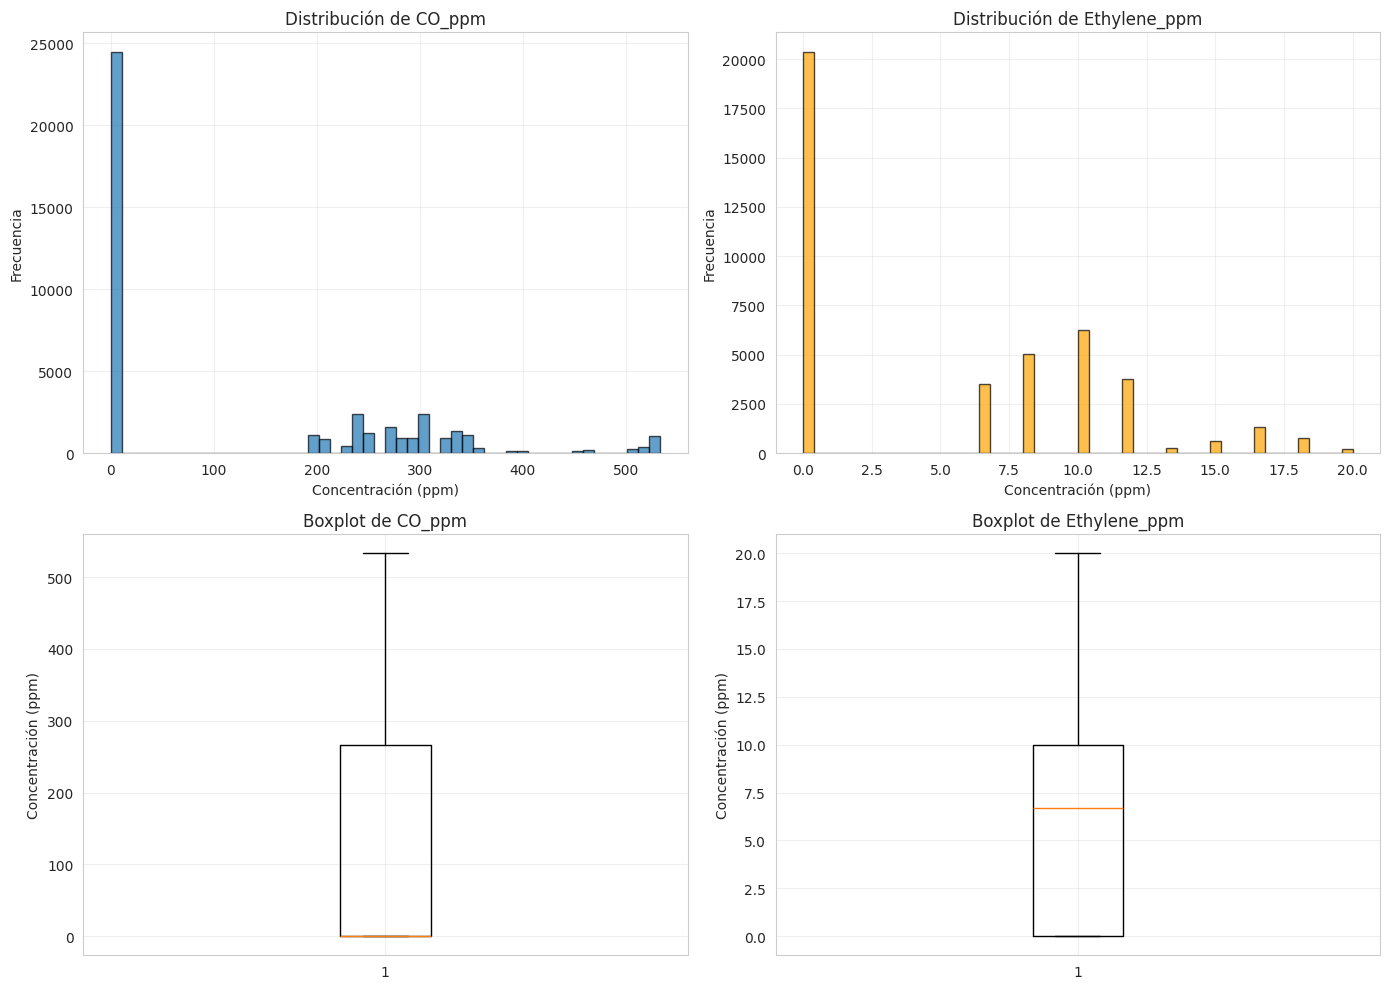


Valores únicos en CO_ppm: 21
Valores únicos en Ethylene_ppm: 10

📊 ETHYLENE + METHANE

Methane_ppm:
count    41757.000000
mean        58.125345
std         76.651261
min          0.000000
25%          0.000000
50%          0.000000
75%        100.000000
max        296.670000
Name: Methane_ppm, dtype: float64

Ethylene_ppm:
count    41757.000000
mean         4.372512
std          5.522079
min          0.000000
25%          0.000000
50%          0.000000
75%          8.330000
max         20.000000
Name: Ethylene_ppm, dtype: float64


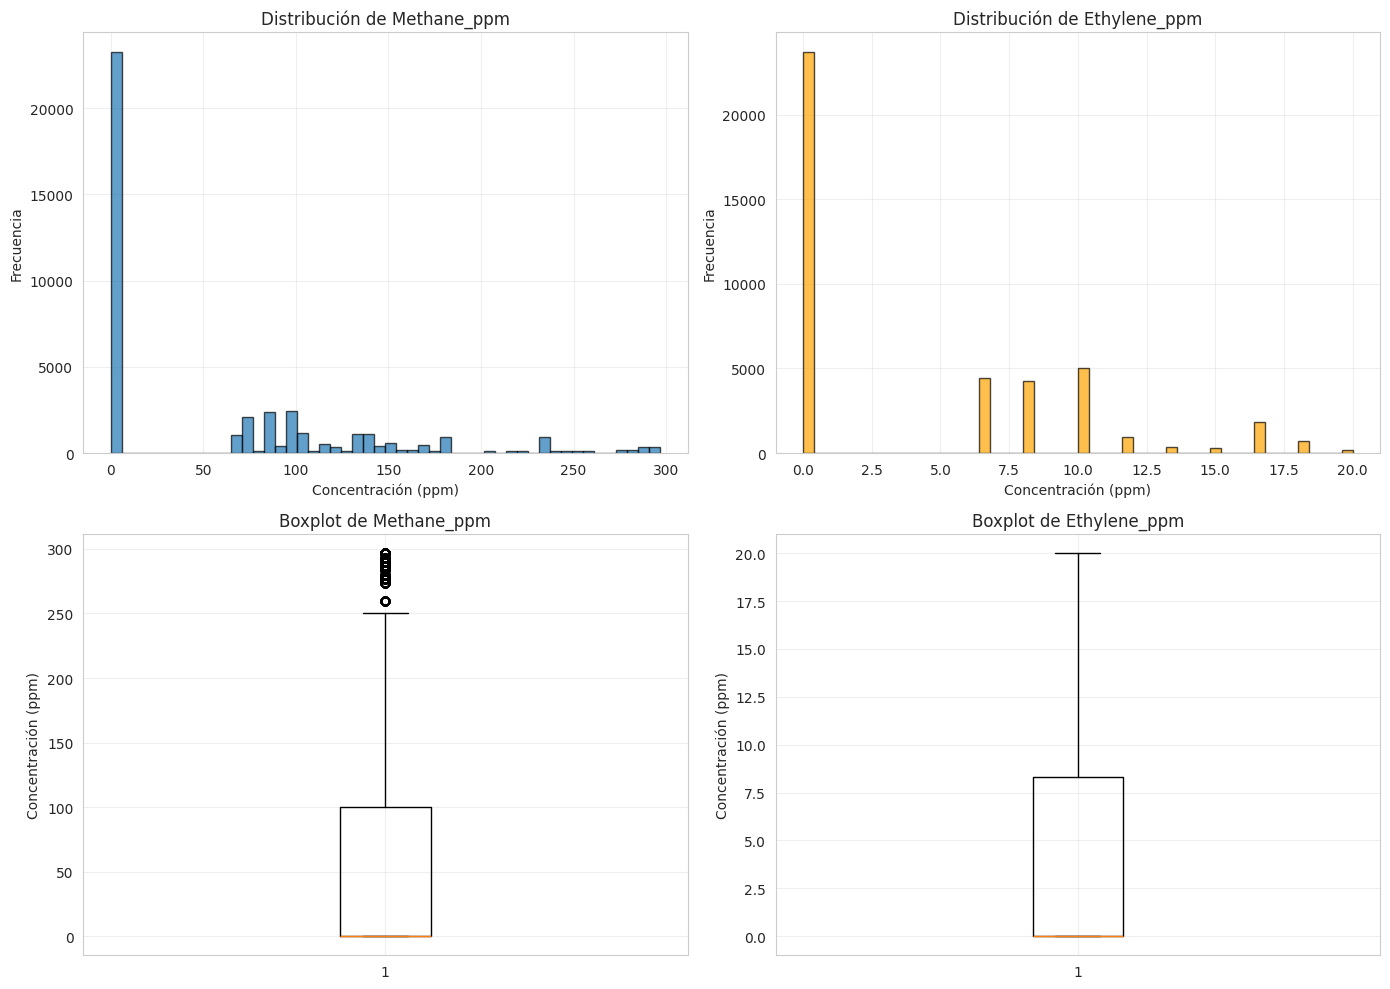


Valores únicos en Methane_ppm: 50
Valores únicos en Ethylene_ppm: 10


In [20]:
# Celda 23: Análisis de Balance - Distribución de concentraciones
print("=" * 70)
print("ANÁLISIS DE BALANCE - DISTRIBUCIÓN DE CONCENTRACIONES")
print("=" * 70)

def analyze_concentration_distribution(df, gas1_col, gas2_col, name):
    """
    Analiza la distribución de concentraciones de ambos gases
    """
    print(f"\n📊 {name}")
    
    # Estadísticas descriptivas
    print(f"\n{gas1_col}:")
    print(df[gas1_col].describe())
    
    print(f"\n{gas2_col}:")
    print(df[gas2_col].describe())
    
    # Crear visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogramas
    axes[0, 0].hist(df[gas1_col], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title(f'Distribución de {gas1_col}')
    axes[0, 0].set_xlabel('Concentración (ppm)')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].hist(df[gas2_col], bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_title(f'Distribución de {gas2_col}')
    axes[0, 1].set_xlabel('Concentración (ppm)')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Boxplots
    axes[1, 0].boxplot(df[gas1_col], vert=True)
    axes[1, 0].set_title(f'Boxplot de {gas1_col}')
    axes[1, 0].set_ylabel('Concentración (ppm)')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].boxplot(df[gas2_col], vert=True)
    axes[1, 1].set_title(f'Boxplot de {gas2_col}')
    axes[1, 1].set_ylabel('Concentración (ppm)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de valores únicos
    print(f"\nValores únicos en {gas1_col}: {df[gas1_col].nunique()}")
    print(f"Valores únicos en {gas2_col}: {df[gas2_col].nunique()}")

# Analizar ambos datasets
analyze_concentration_distribution(df_co_clean, 'CO_ppm', 'Ethylene_ppm', 'ETHYLENE + CO')
analyze_concentration_distribution(df_methane_clean, 'Methane_ppm', 'Ethylene_ppm', 'ETHYLENE + METHANE')

ANÁLISIS DE BALANCE - DURACIÓN DE FASES

📊 ETHYLENE + CO

Total de muestras: 42,054
Gas puro: 32,388 (77.0%)
Mezcla: 9,666 (23.0%)


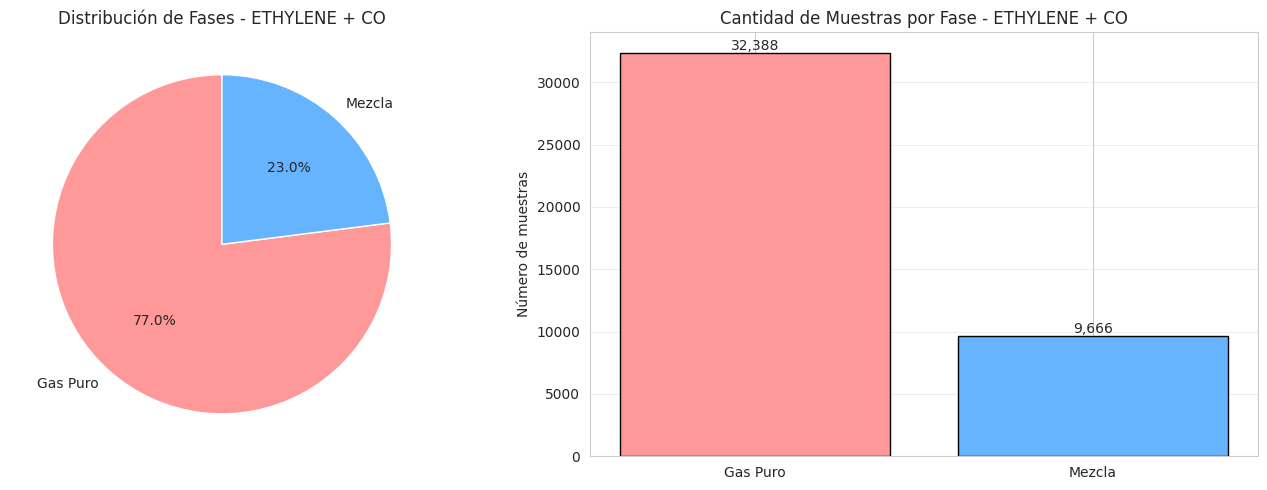


📊 ETHYLENE + METHANE

Total de muestras: 41,757
Gas puro: 33,271 (79.7%)
Mezcla: 8,486 (20.3%)


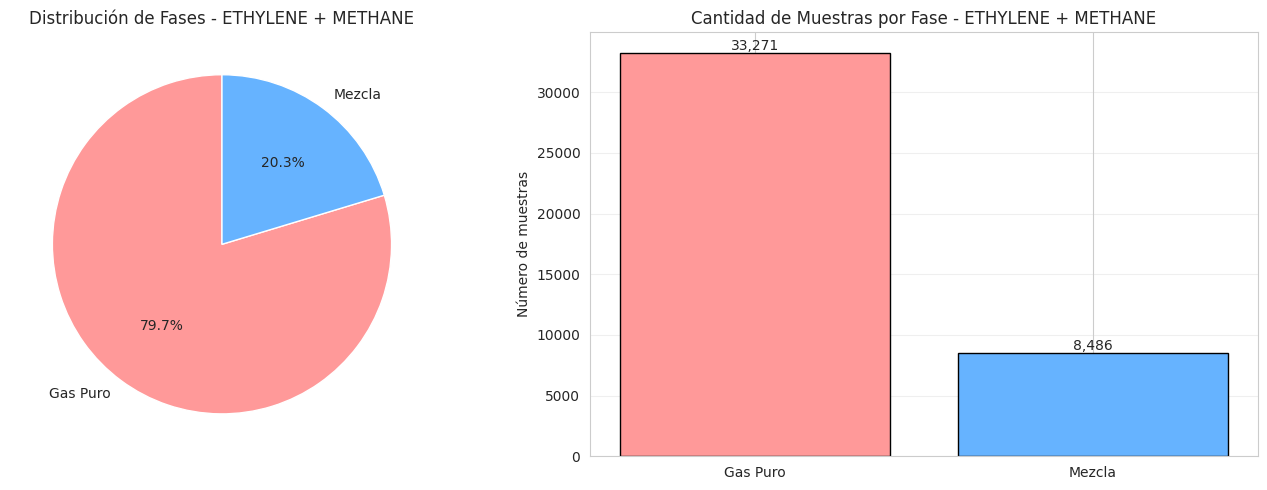

In [21]:
# Celda 24: Análisis de Balance - Duración de fases (gas puro vs mezcla)
print("=" * 70)
print("ANÁLISIS DE BALANCE - DURACIÓN DE FASES")
print("=" * 70)

def analyze_phase_duration(df, gas1_col, gas2_col, name):
    """
    Analiza la duración de las diferentes fases de operación
    """
    print(f"\n📊 {name}")
    
    # Identificar fases
    gas_puro = ((df[gas1_col] == 0) | (df[gas2_col] == 0)).sum()
    mezcla = ((df[gas1_col] > 0) & (df[gas2_col] > 0)).sum()
    
    total = len(df)
    pct_puro = (gas_puro / total) * 100
    pct_mezcla = (mezcla / total) * 100
    
    print(f"\nTotal de muestras: {total:,}")
    print(f"Gas puro: {gas_puro:,} ({pct_puro:.1f}%)")
    print(f"Mezcla: {mezcla:,} ({pct_mezcla:.1f}%)")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart
    labels = ['Gas Puro', 'Mezcla']
    sizes = [gas_puro, mezcla]
    colors = ['#ff9999', '#66b3ff']
    
    axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0].set_title(f'Distribución de Fases - {name}')
    
    # Gráfico de barras
    axes[1].bar(labels, sizes, color=colors, edgecolor='black')
    axes[1].set_title(f'Cantidad de Muestras por Fase - {name}')
    axes[1].set_ylabel('Número de muestras')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Añadir valores en las barras
    for i, v in enumerate(sizes):
        axes[1].text(i, v, f'{v:,}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Analizar ambos datasets
analyze_phase_duration(df_co_clean, 'CO_ppm', 'Ethylene_ppm', 'ETHYLENE + CO')
analyze_phase_duration(df_methane_clean, 'Methane_ppm', 'Ethylene_ppm', 'ETHYLENE + METHANE')

ANÁLISIS DE TRANSICIONES

📊 ETHYLENE + CO

Transiciones detectadas en CO_ppm: 192
Transiciones detectadas en Ethylene_ppm: 184


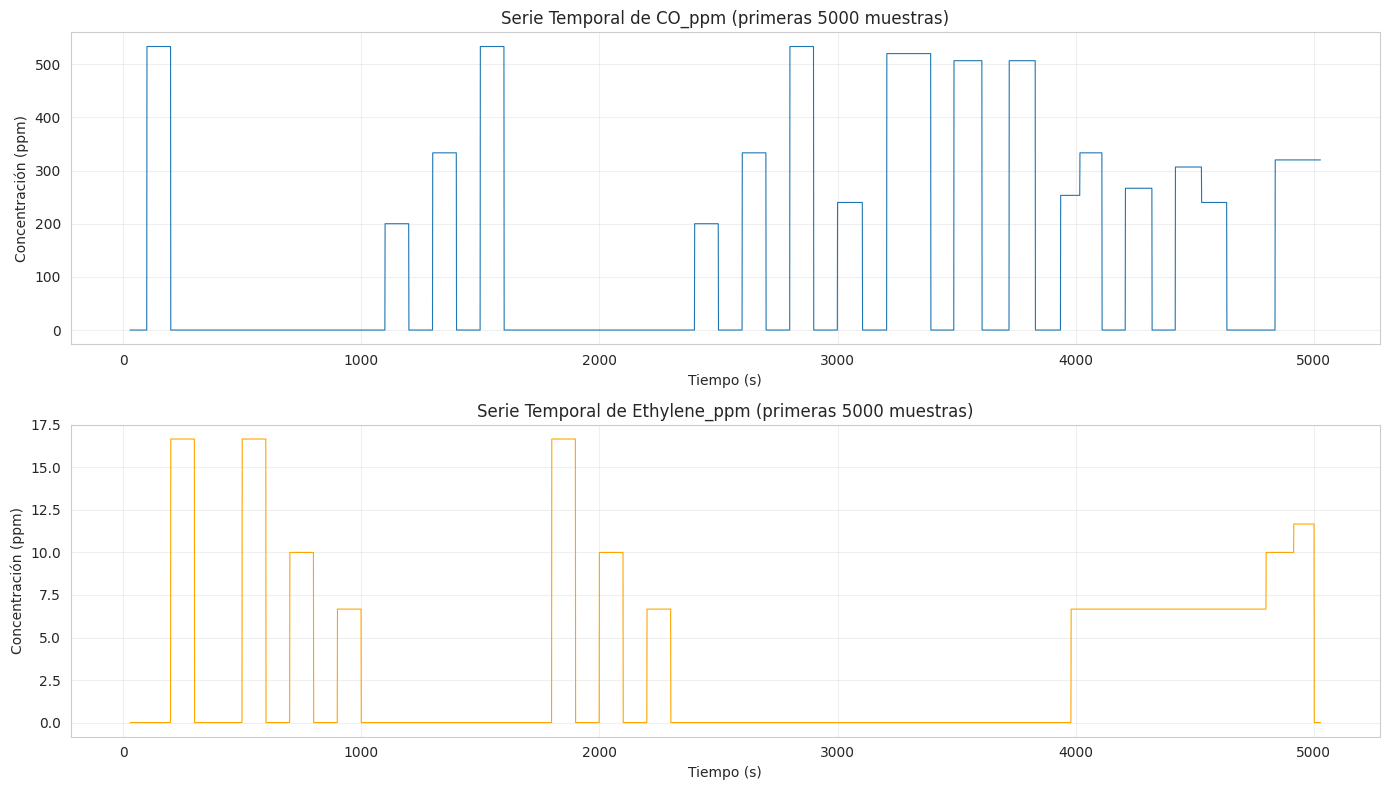


📊 ETHYLENE + METHANE

Transiciones detectadas en Methane_ppm: 184
Transiciones detectadas en Ethylene_ppm: 171


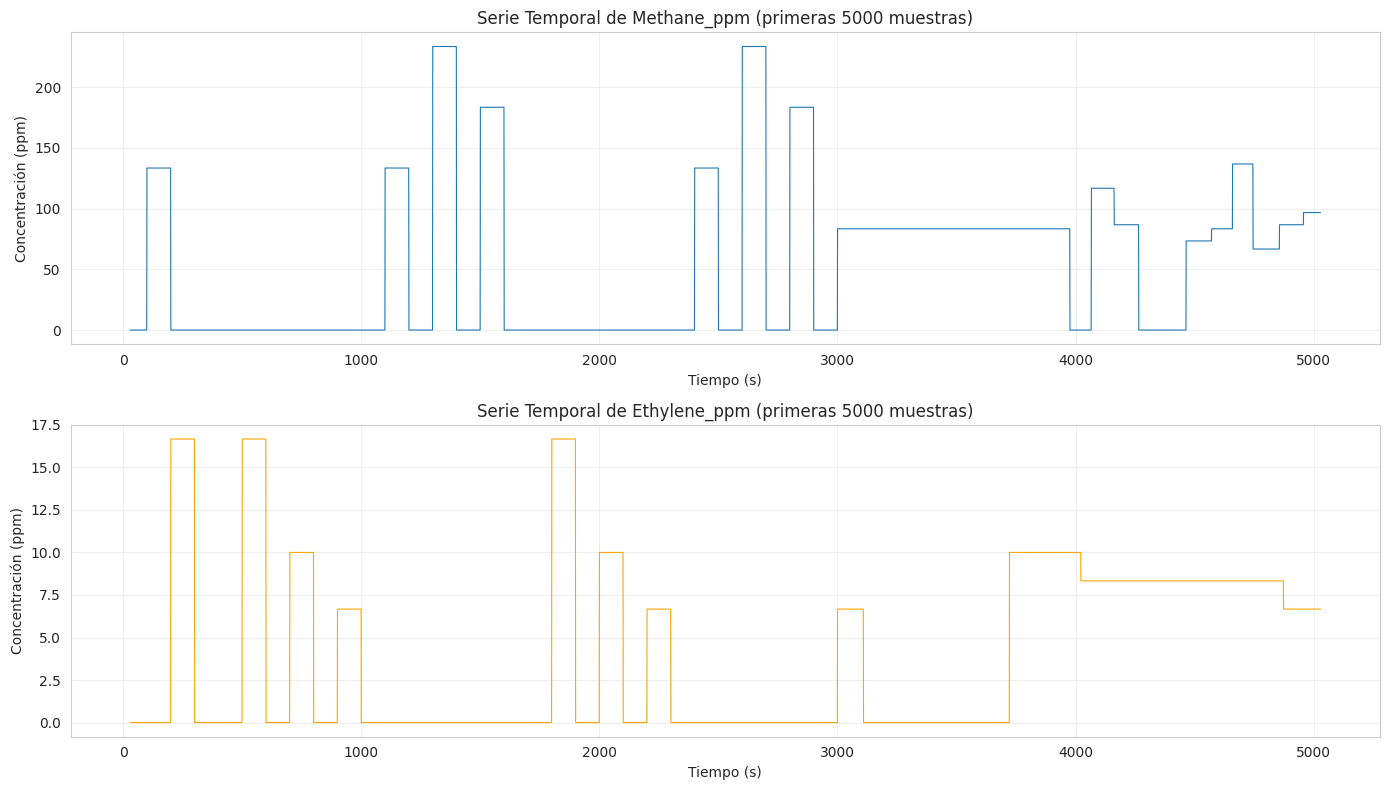

In [22]:
# Celda 25: Análisis de transiciones
print("=" * 70)
print("ANÁLISIS DE TRANSICIONES")
print("=" * 70)

def analyze_transitions(df, gas1_col, gas2_col, name):
    """
    Analiza las transiciones entre diferentes niveles de concentración
    """
    print(f"\n📊 {name}")
    
    # Detectar cambios en concentración
    gas1_changes = (df[gas1_col].diff() != 0).sum()
    gas2_changes = (df[gas2_col].diff() != 0).sum()
    
    print(f"\nTransiciones detectadas en {gas1_col}: {gas1_changes}")
    print(f"Transiciones detectadas en {gas2_col}: {gas2_changes}")
    
    # Visualización de serie temporal (primeras 5000 muestras)
    sample_size = min(5000, len(df))
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    axes[0].plot(df['Time'][:sample_size], df[gas1_col][:sample_size], linewidth=0.8)
    axes[0].set_title(f'Serie Temporal de {gas1_col} (primeras {sample_size} muestras)')
    axes[0].set_xlabel('Tiempo (s)')
    axes[0].set_ylabel('Concentración (ppm)')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(df['Time'][:sample_size], df[gas2_col][:sample_size], linewidth=0.8, color='orange')
    axes[1].set_title(f'Serie Temporal de {gas2_col} (primeras {sample_size} muestras)')
    axes[1].set_xlabel('Tiempo (s)')
    axes[1].set_ylabel('Concentración (ppm)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analizar ambos datasets
analyze_transitions(df_co_clean, 'CO_ppm', 'Ethylene_ppm', 'ETHYLENE + CO')
analyze_transitions(df_methane_clean, 'Methane_ppm', 'Ethylene_ppm', 'ETHYLENE + METHANE')

CARACTERIZACIÓN DE SENSORES - ESTADÍSTICAS POR TIPO

📊 ETHYLENE + CO

Estadísticas por tipo de sensor:

TGS-2600:
  Media: 2937.28
  Std: 1401.60
  Min: -16.70
  Max: 22529.29

TGS-2602:
  Media: 3646.90
  Std: 1224.72
  Min: 1069.93
  Max: 10438.63

TGS-2610:
  Media: 2801.34
  Std: 974.17
  Min: 176.10
  Max: 9293.00

TGS-2620:
  Media: 2891.54
  Std: 968.43
  Min: 633.35
  Max: 10624.42


/tmp/ipykernel_724/192424877.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([df[s] for s in sensors], labels=sensors)
/tmp/ipykernel_724/192424877.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([df[s] for s in sensors], labels=sensors)
/tmp/ipykernel_724/192424877.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([df[s] for s in sensors], labels=sensors)
/tmp/ipykernel_724/192424877.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 

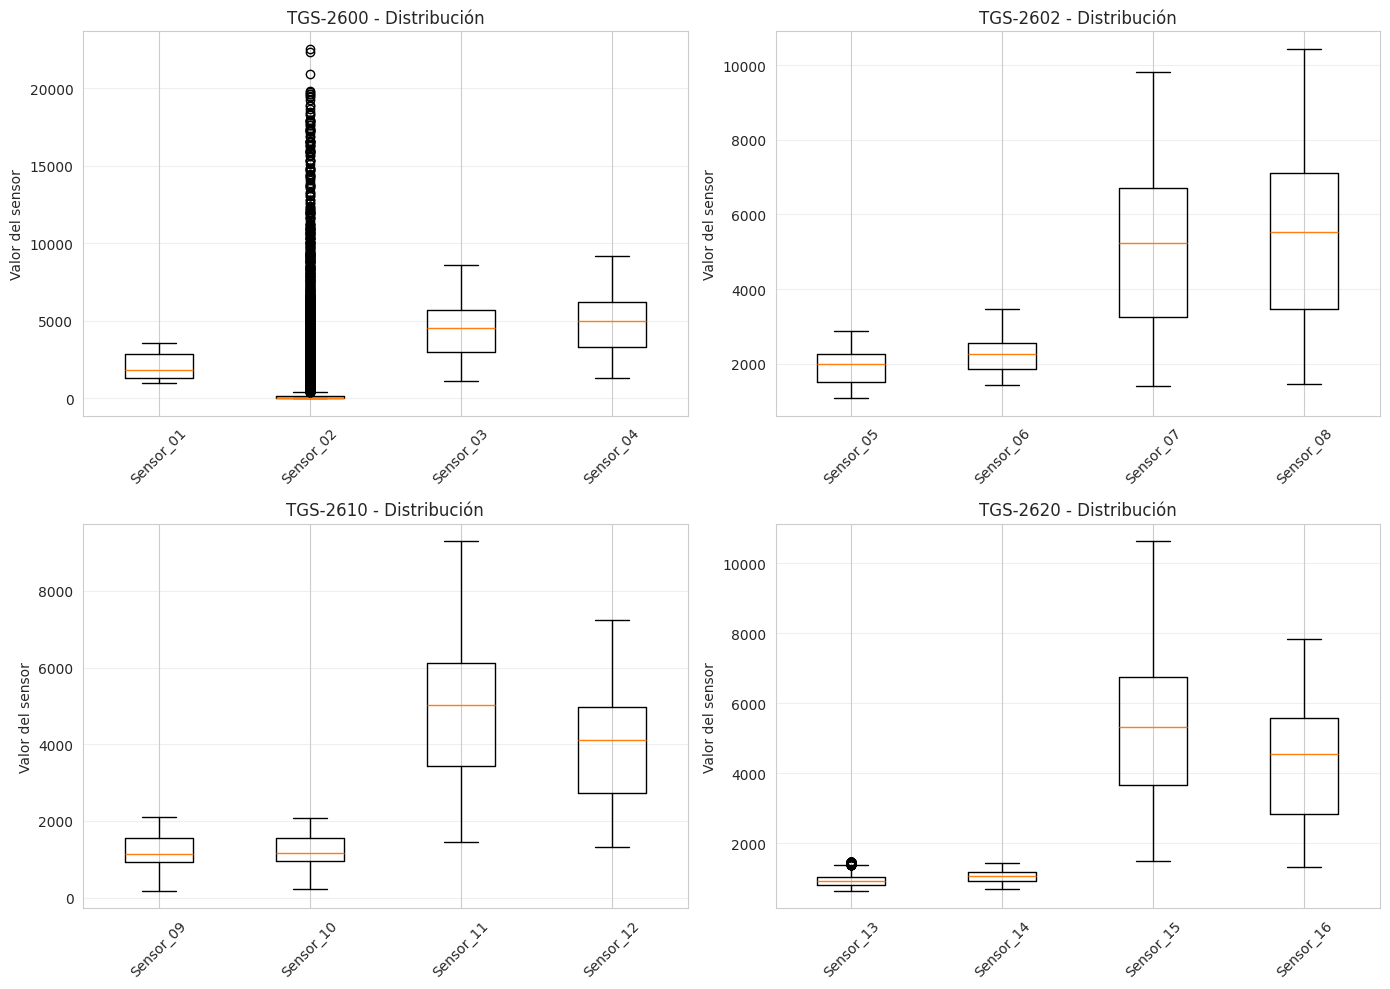


📊 ETHYLENE + METHANE

Estadísticas por tipo de sensor:

TGS-2600:
  Media: 2505.62
  Std: 689.10
  Min: 760.72
  Max: 5959.73

TGS-2602:
  Media: 2478.86
  Std: 1212.40
  Min: 493.34
  Max: 5777.52

TGS-2610:
  Media: 2672.48
  Std: 567.16
  Min: 607.61
  Max: 4817.55

TGS-2620:
  Media: 1915.39
  Std: 952.11
  Min: 441.85
  Max: 4668.51


/tmp/ipykernel_724/192424877.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([df[s] for s in sensors], labels=sensors)
/tmp/ipykernel_724/192424877.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([df[s] for s in sensors], labels=sensors)
/tmp/ipykernel_724/192424877.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot([df[s] for s in sensors], labels=sensors)
/tmp/ipykernel_724/192424877.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 

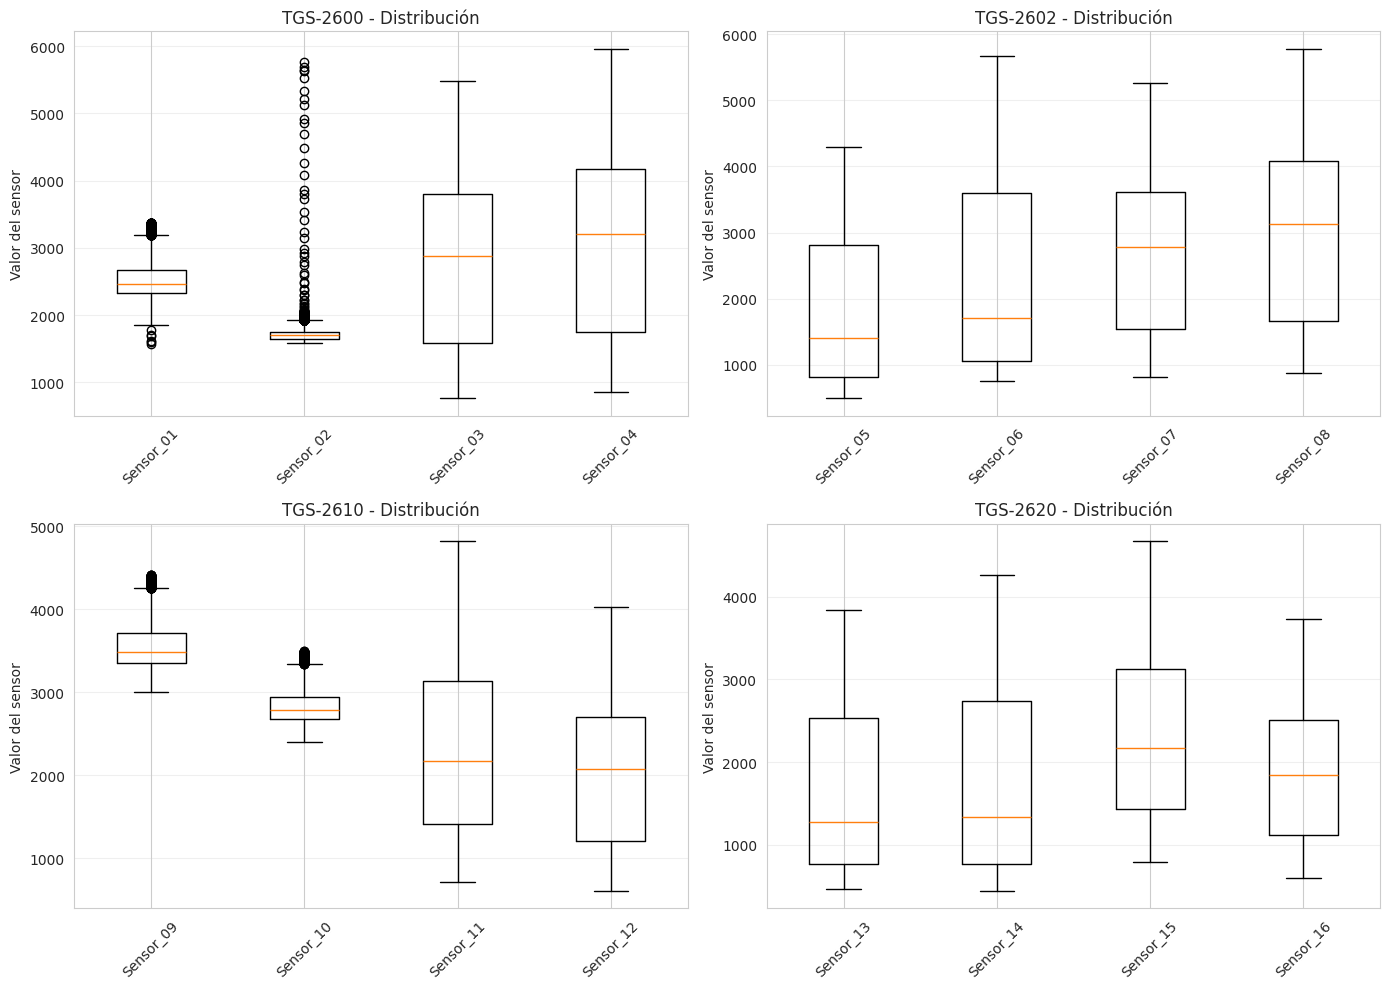

In [23]:
# Celda 26: Caracterización de sensores - Estadísticas por tipo
print("=" * 70)
print("CARACTERIZACIÓN DE SENSORES - ESTADÍSTICAS POR TIPO")
print("=" * 70)

def analyze_sensor_types(df, name):
    """
    Analiza las características de cada tipo de sensor
    """
    print(f"\n📊 {name}")
    
    # Agrupar sensores por tipo (cada 4 sensores son del mismo tipo)
    sensor_types = {
        'TGS-2600': ['Sensor_01', 'Sensor_02', 'Sensor_03', 'Sensor_04'],
        'TGS-2602': ['Sensor_05', 'Sensor_06', 'Sensor_07', 'Sensor_08'],
        'TGS-2610': ['Sensor_09', 'Sensor_10', 'Sensor_11', 'Sensor_12'],
        'TGS-2620': ['Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16']
    }
    
    print("\nEstadísticas por tipo de sensor:")
    
    for sensor_type, sensors in sensor_types.items():
        print(f"\n{sensor_type}:")
        sensor_data = df[sensors]
        print(f"  Media: {sensor_data.mean().mean():.2f}")
        print(f"  Std: {sensor_data.std().mean():.2f}")
        print(f"  Min: {sensor_data.min().min():.2f}")
        print(f"  Max: {sensor_data.max().max():.2f}")
    
    # Visualización comparativa
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (sensor_type, sensors) in enumerate(sensor_types.items()):
        sensor_data = df[sensors]
        
        # Boxplot comparativo de los 4 sensores del mismo tipo
        axes[idx].boxplot([df[s] for s in sensors], labels=sensors)
        axes[idx].set_title(f'{sensor_type} - Distribución')
        axes[idx].set_ylabel('Valor del sensor')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# Analizar ambos datasets
analyze_sensor_types(df_co_clean, 'ETHYLENE + CO')
analyze_sensor_types(df_methane_clean, 'ETHYLENE + METHANE')

ANÁLISIS DE REDUNDANCIA - CORRELACIÓN ENTRE SENSORES

📊 ETHYLENE + CO

TGS-2600:
  Correlación promedio: 0.315
  Correlación mínima: -0.049
  Correlación máxima: 0.999

TGS-2602:
  Correlación promedio: 0.873
  Correlación mínima: 0.762
  Correlación máxima: 1.000

TGS-2610:
  Correlación promedio: 0.689
  Correlación mínima: 0.526
  Correlación máxima: 0.995

TGS-2620:
  Correlación promedio: 0.742
  Correlación mínima: 0.482
  Correlación máxima: 0.972


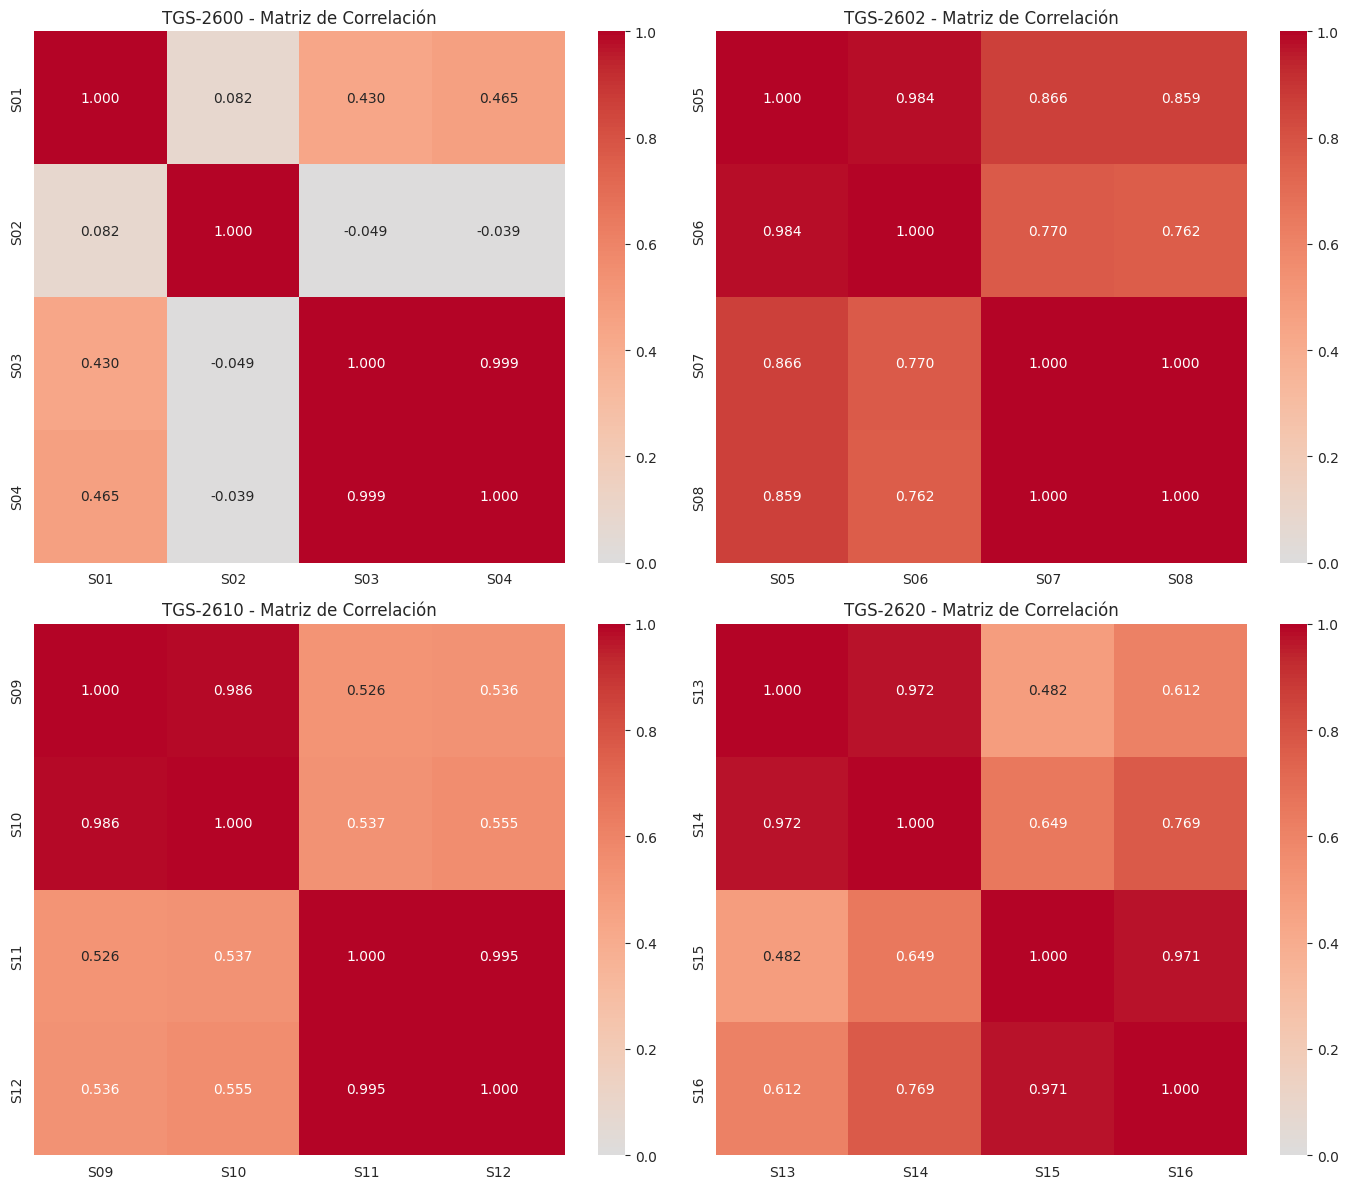


📊 ETHYLENE + METHANE

TGS-2600:
  Correlación promedio: 0.294
  Correlación mínima: -0.289
  Correlación máxima: 0.999

TGS-2602:
  Correlación promedio: 0.769
  Correlación mínima: 0.598
  Correlación máxima: 0.998

TGS-2610:
  Correlación promedio: 0.810
  Correlación mínima: 0.646
  Correlación máxima: 0.997

TGS-2620:
  Correlación promedio: 0.618
  Correlación mínima: 0.369
  Correlación máxima: 1.000


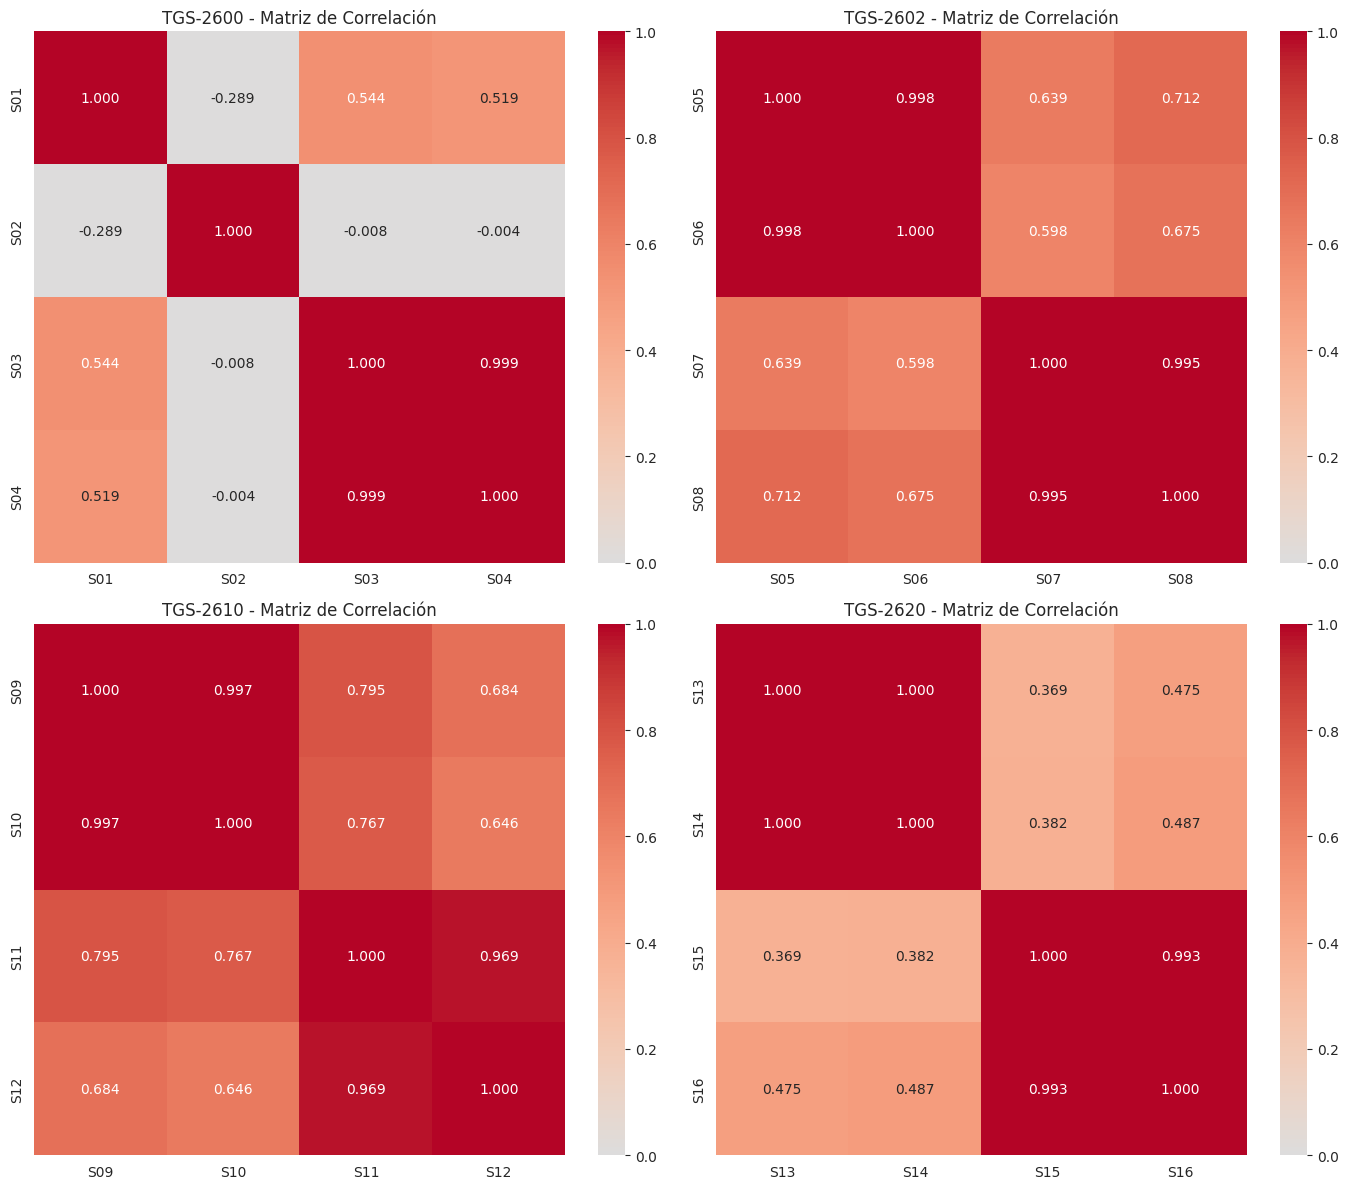

In [24]:
# Celda 27: Análisis de redundancia entre sensores del mismo tipo
print("=" * 70)
print("ANÁLISIS DE REDUNDANCIA - CORRELACIÓN ENTRE SENSORES")
print("=" * 70)

def analyze_sensor_redundancy(df, name):
    """
    Analiza la correlación entre sensores del mismo tipo (redundancia)
    """
    print(f"\n📊 {name}")
    
    # Agrupar sensores por tipo
    sensor_types = {
        'TGS-2600': ['Sensor_01', 'Sensor_02', 'Sensor_03', 'Sensor_04'],
        'TGS-2602': ['Sensor_05', 'Sensor_06', 'Sensor_07', 'Sensor_08'],
        'TGS-2610': ['Sensor_09', 'Sensor_10', 'Sensor_11', 'Sensor_12'],
        'TGS-2620': ['Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16']
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, (sensor_type, sensors) in enumerate(sensor_types.items()):
        # Calcular matriz de correlación
        corr_matrix = df[sensors].corr()
        
        # Heatmap
        sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                    center=0, vmin=0, vmax=1, ax=axes[idx],
                    xticklabels=[s.replace('Sensor_', 'S') for s in sensors],
                    yticklabels=[s.replace('Sensor_', 'S') for s in sensors])
        axes[idx].set_title(f'{sensor_type} - Matriz de Correlación')
        
        # Imprimir correlaciones promedio
        corr_values = corr_matrix.values
        upper_triangle = corr_values[np.triu_indices_from(corr_values, k=1)]
        avg_corr = upper_triangle.mean()
        
        print(f"\n{sensor_type}:")
        print(f"  Correlación promedio: {avg_corr:.3f}")
        print(f"  Correlación mínima: {upper_triangle.min():.3f}")
        print(f"  Correlación máxima: {upper_triangle.max():.3f}")
    
    plt.tight_layout()
    plt.show()

# Analizar ambos datasets
analyze_sensor_redundancy(df_co_clean, 'ETHYLENE + CO')
analyze_sensor_redundancy(df_methane_clean, 'ETHYLENE + METHANE')

ANÁLISIS DE DERIVA TEMPORAL (DRIFT)

📊 ETHYLENE + CO

Sensor_01:
  Pendiente de deriva: -0.015593 por muestra
  Deriva total estimada: -655.741

Sensor_05:
  Pendiente de deriva: -0.011509 por muestra
  Deriva total estimada: -484.014

Sensor_09:
  Pendiente de deriva: 0.015597 por muestra
  Deriva total estimada: 655.921

Sensor_13:
  Pendiente de deriva: -0.007685 por muestra
  Deriva total estimada: -323.173


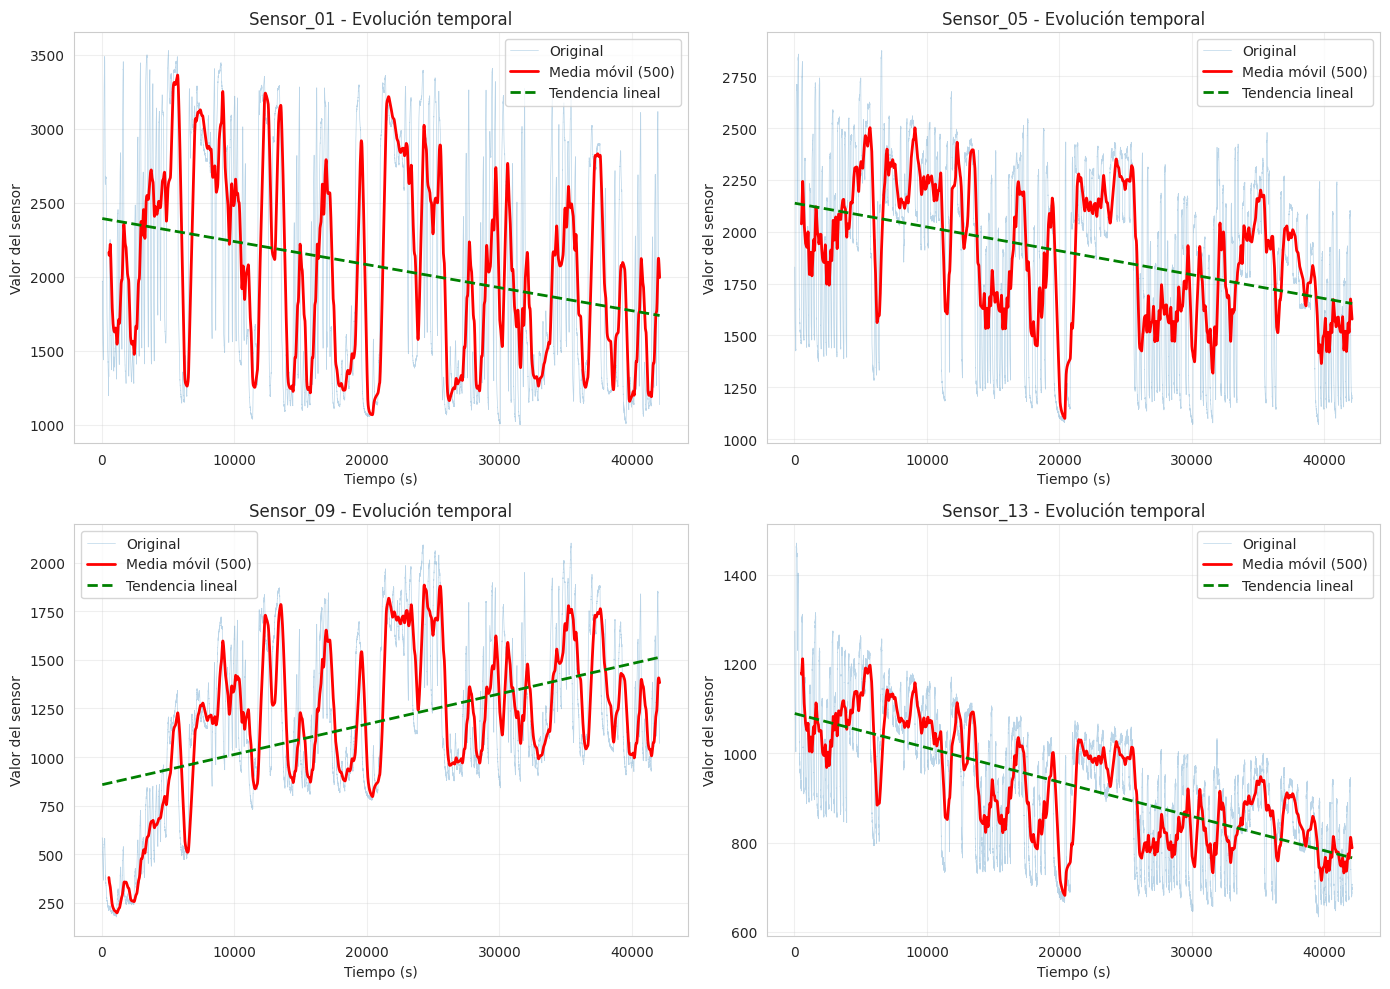


📊 ETHYLENE + METHANE

Sensor_01:
  Pendiente de deriva: 0.006805 por muestra
  Deriva total estimada: 284.153

Sensor_05:
  Pendiente de deriva: -0.010055 por muestra
  Deriva total estimada: -419.858

Sensor_09:
  Pendiente de deriva: 0.007185 por muestra
  Deriva total estimada: 300.039

Sensor_13:
  Pendiente de deriva: -0.008628 por muestra
  Deriva total estimada: -360.259


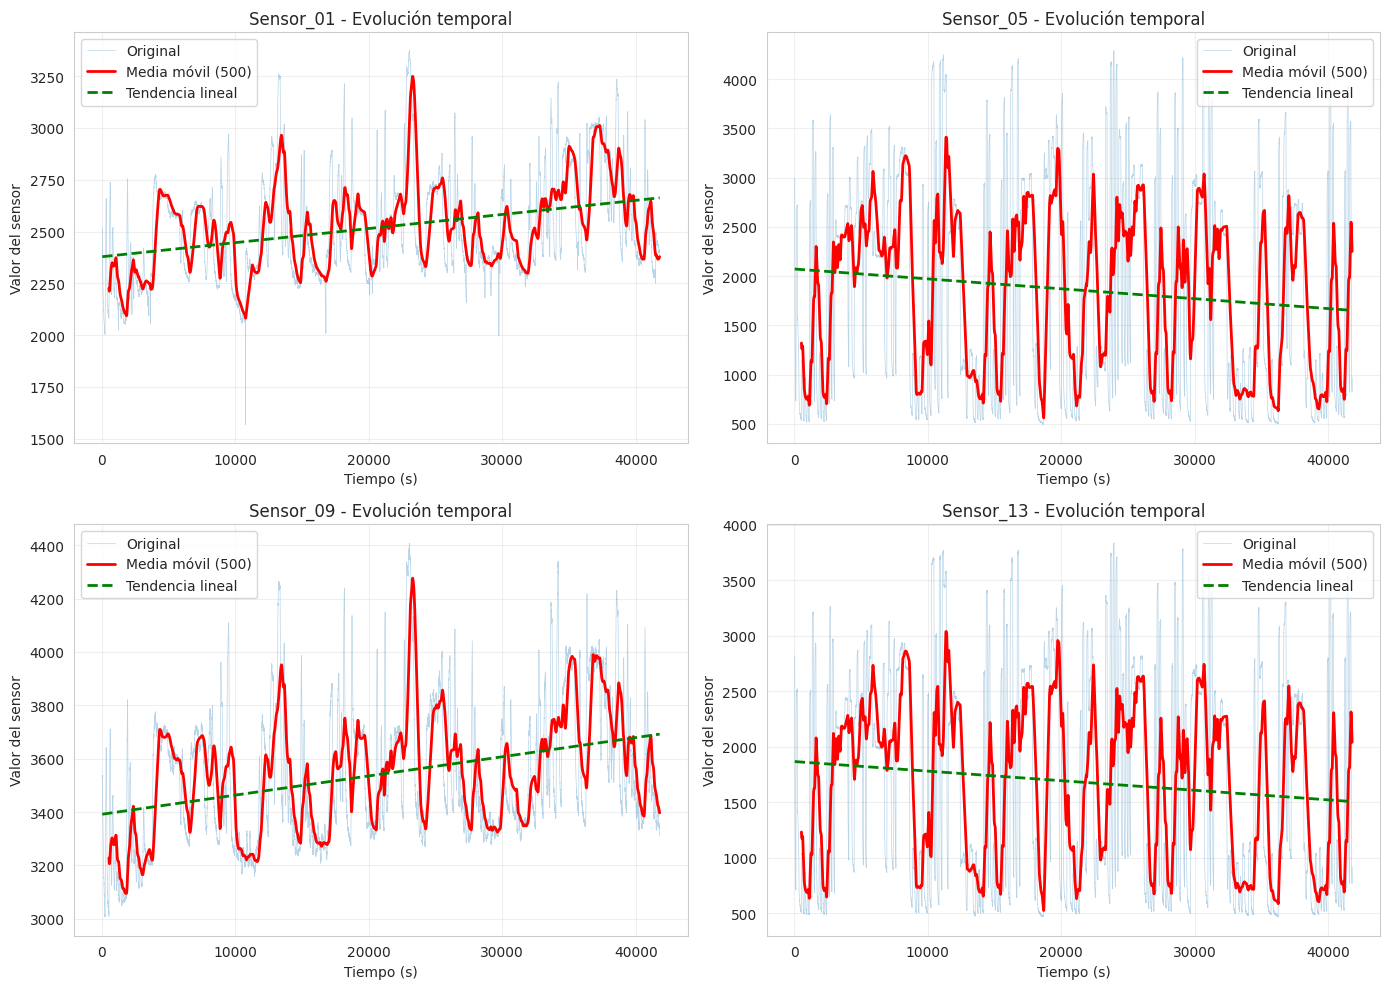

In [25]:
# Celda 28: Análisis de deriva temporal (drift)
print("=" * 70)
print("ANÁLISIS DE DERIVA TEMPORAL (DRIFT)")
print("=" * 70)

def analyze_temporal_drift(df, name, sample_interval=1000):
    """
    Analiza la evolución temporal de los sensores para detectar deriva
    """
    print(f"\n📊 {name}")
    
    # Seleccionar algunos sensores representativos (uno de cada tipo)
    representative_sensors = ['Sensor_01', 'Sensor_05', 'Sensor_09', 'Sensor_13']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, sensor in enumerate(representative_sensors):
        # Calcular media móvil a largo plazo
        long_window = 500
        rolling_mean = df[sensor].rolling(window=long_window).mean()
        
        # Plotear sensor original y media móvil
        axes[idx].plot(df['Time'], df[sensor], alpha=0.3, linewidth=0.5, label='Original')
        axes[idx].plot(df['Time'], rolling_mean, linewidth=2, color='red', label=f'Media móvil ({long_window})')
        axes[idx].set_title(f'{sensor} - Evolución temporal')
        axes[idx].set_xlabel('Tiempo (s)')
        axes[idx].set_ylabel('Valor del sensor')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
        # Calcular tendencia lineal
        z = np.polyfit(range(len(df)), df[sensor], 1)
        p = np.poly1d(z)
        axes[idx].plot(df['Time'], p(range(len(df))), "--", linewidth=2, color='green', label='Tendencia lineal')
        axes[idx].legend()
        
        # Imprimir estadísticas de deriva
        drift_slope = z[0]
        print(f"\n{sensor}:")
        print(f"  Pendiente de deriva: {drift_slope:.6f} por muestra")
        print(f"  Deriva total estimada: {drift_slope * len(df):.3f}")
    
    plt.tight_layout()
    plt.show()

# Analizar ambos datasets
analyze_temporal_drift(df_co_clean, 'ETHYLENE + CO')
analyze_temporal_drift(df_methane_clean, 'ETHYLENE + METHANE')

ANÁLISIS DE RESPUESTA - TIEMPO DE SUBIDA/ASENTAMIENTO

📊 ETHYLENE + CO


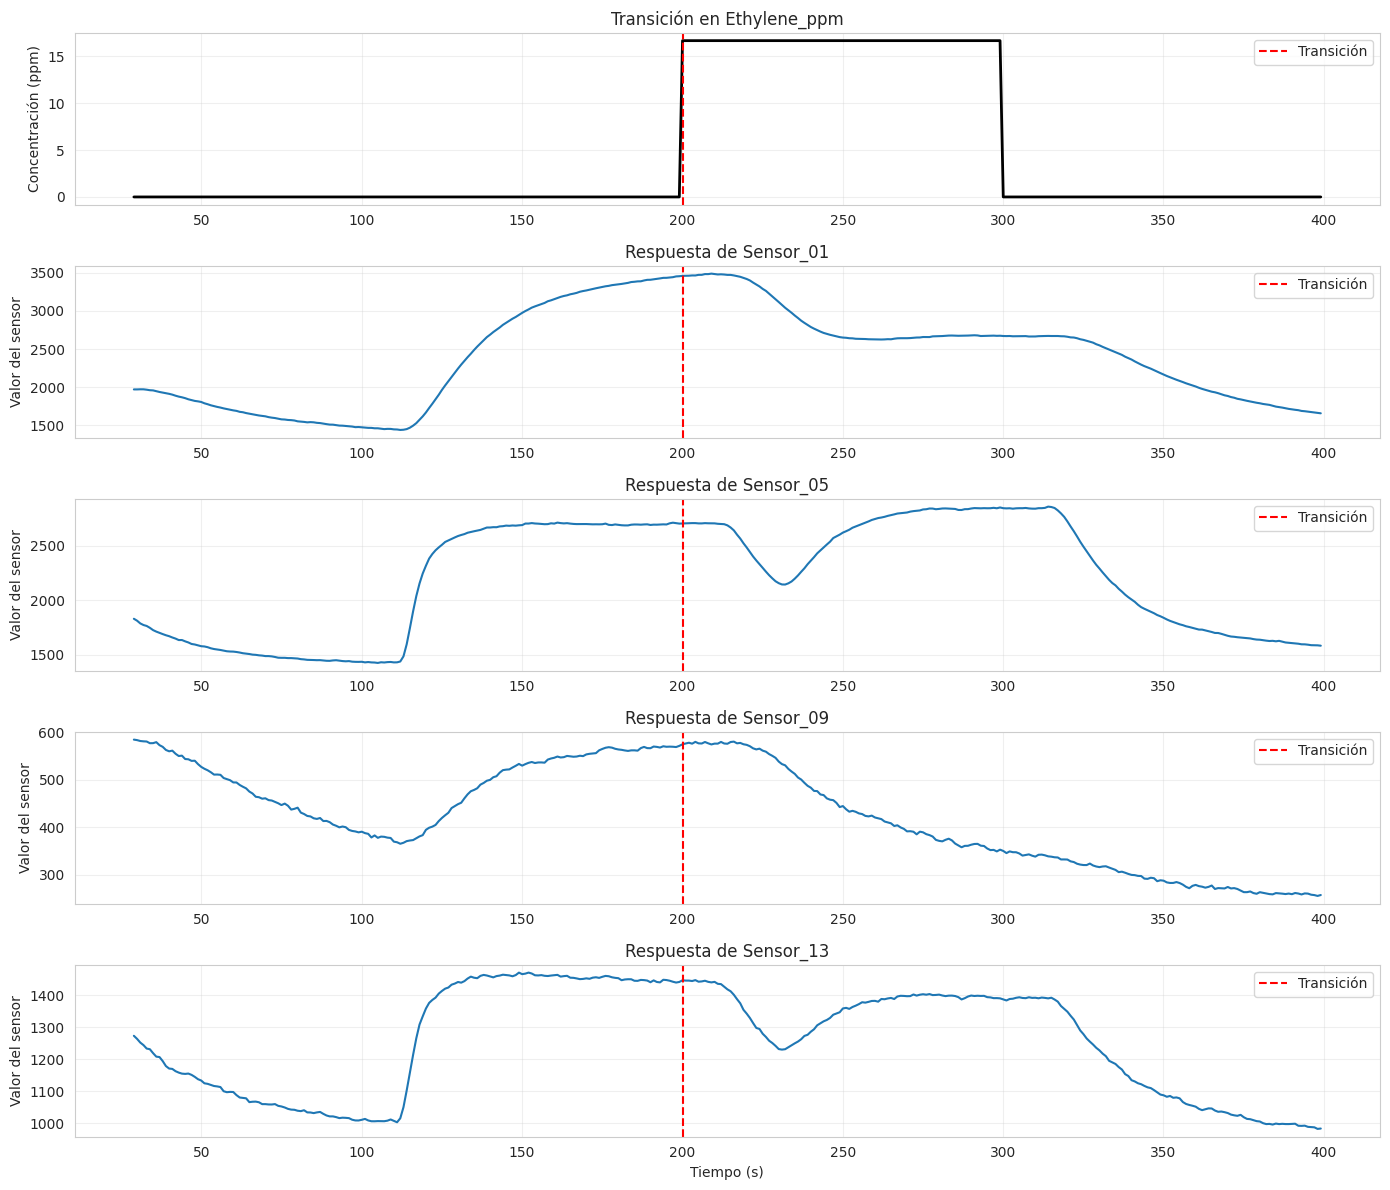


  Transición analizada en índice 171
  Tiempo: 200.06 s

📊 ETHYLENE + METHANE


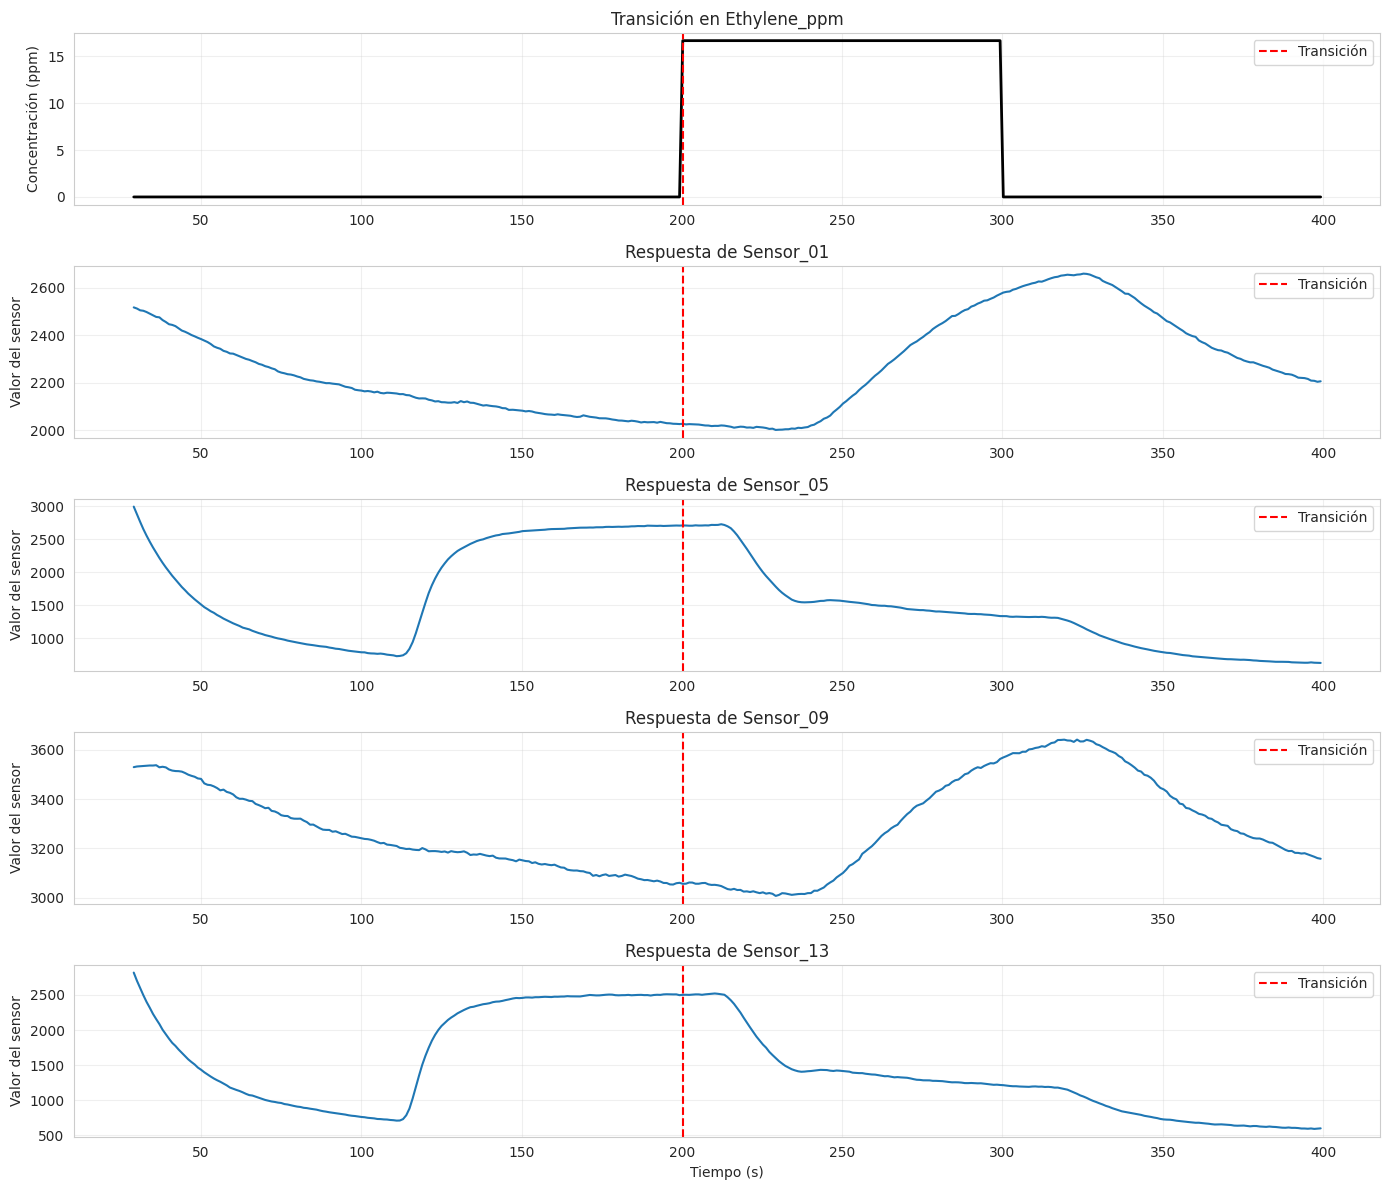


  Transición analizada en índice 171
  Tiempo: 200.27 s


In [26]:
# Celda 29: Análisis de respuesta de sensores a cambios de concentración
print("=" * 70)
print("ANÁLISIS DE RESPUESTA - TIEMPO DE SUBIDA/ASENTAMIENTO")
print("=" * 70)

def analyze_sensor_response(df, gas1_col, gas2_col, name):
    """
    Analiza cómo responden los sensores a cambios en concentración
    """
    print(f"\n📊 {name}")
    
    # Detectar una transición significativa
    gas_diff = df[gas2_col].diff().abs()
    transition_idx = gas_diff[gas_diff > 10].index[:5]  # Primeras 5 transiciones grandes
    
    if len(transition_idx) == 0:
        print("  No se encontraron transiciones significativas")
        return
    
    # Tomar la primera transición
    idx = transition_idx[0]
    window = 200  # Ventana alrededor de la transición
    
    start = max(0, idx - window)
    end = min(len(df), idx + window)
    
    # Sensores representativos
    representative_sensors = ['Sensor_01', 'Sensor_05', 'Sensor_09', 'Sensor_13']
    
    fig, axes = plt.subplots(len(representative_sensors) + 1, 1, figsize=(14, 12))
    
    # Plot de concentración
    axes[0].plot(df['Time'][start:end], df[gas2_col][start:end], linewidth=2, color='black')
    axes[0].axvline(x=df['Time'][idx], color='red', linestyle='--', label='Transición')
    axes[0].set_title(f'Transición en {gas2_col}')
    axes[0].set_ylabel('Concentración (ppm)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot de sensores
    for i, sensor in enumerate(representative_sensors, start=1):
        axes[i].plot(df['Time'][start:end], df[sensor][start:end], linewidth=1.5)
        axes[i].axvline(x=df['Time'][idx], color='red', linestyle='--', label='Transición')
        axes[i].set_title(f'Respuesta de {sensor}')
        axes[i].set_ylabel('Valor del sensor')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Tiempo (s)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n  Transición analizada en índice {idx}")
    print(f"  Tiempo: {df['Time'][idx]:.2f} s")

# Analizar ambos datasets
analyze_sensor_response(df_co_clean, 'CO_ppm', 'Ethylene_ppm', 'ETHYLENE + CO')
analyze_sensor_response(df_methane_clean, 'Methane_ppm', 'Ethylene_ppm', 'ETHYLENE + METHANE')

In [27]:
# Celda 31: Preparación de datos - Separar features (X) y targets (y)
print("=" * 70)
print("PREPARACIÓN DE DATOS PARA MODELADO")
print("=" * 70)

def prepare_modeling_data(df, gas1_col, gas2_col, name):
    """
    Separa features (X) y targets (y) para modelado
    """
    print(f"\n📊 {name}")
    
    # Identificar columnas de sensores y features
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_')]
    
    # Features: todas las columnas de sensores y sus derivadas, más contexto
    feature_cols = sensor_cols + ['gas_type', 'pure_gas', 'total_concentration']
    
    # Targets: concentraciones de ambos gases
    target_cols = [gas1_col, gas2_col]
    
    # Separar X e y
    X = df[feature_cols].copy()
    y = df[target_cols].copy()
    
    print(f"  Features (X): {X.shape}")
    print(f"  Targets (y): {y.shape}")
    print(f"\n  Columnas de features: {len(feature_cols)}")
    print(f"  Columnas de targets: {len(target_cols)}")
    
    return X, y, feature_cols, target_cols

# Preparar datos para ambos datasets
X_co, y_co, features_co, targets_co = prepare_modeling_data(
    df_co_clean, 'CO_ppm', 'Ethylene_ppm', 'ETHYLENE + CO'
)

X_methane, y_methane, features_methane, targets_methane = prepare_modeling_data(
    df_methane_clean, 'Methane_ppm', 'Ethylene_ppm', 'ETHYLENE + METHANE'
)

print("\n✓ Datos preparados para modelado")

PREPARACIÓN DE DATOS PARA MODELADO

📊 ETHYLENE + CO
  Features (X): (42054, 307)
  Targets (y): (42054, 2)

  Columnas de features: 307
  Columnas de targets: 2

📊 ETHYLENE + METHANE
  Features (X): (41757, 307)
  Targets (y): (41757, 2)

  Columnas de features: 307
  Columnas de targets: 2

✓ Datos preparados para modelado


In [28]:
# Celda 32: Partición temporal estricta (train-validation-test)
print("=" * 70)
print("PARTICIÓN TEMPORAL (TRAIN-VALIDATION-TEST)")
print("=" * 70)

def temporal_split(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Divide los datos de forma temporal para evitar data leakage
    train_ratio: proporción para entrenamiento
    val_ratio: proporción para validación
    test_ratio: proporción para prueba
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Las proporciones deben sumar 1"
    
    n = len(X)
    
    # Calcular índices de corte
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    # Dividir datos cronológicamente
    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]
    
    X_val = X.iloc[train_end:val_end]
    y_val = y.iloc[train_end:val_end]
    
    X_test = X.iloc[val_end:]
    y_test = y.iloc[val_end:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Configuración de proporciones
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"Proporciones: Train={TRAIN_RATIO}, Val={VAL_RATIO}, Test={TEST_RATIO}")

# Dividir dataset CO
X_train_co, X_val_co, X_test_co, y_train_co, y_val_co, y_test_co = temporal_split(
    X_co, y_co, TRAIN_RATIO, VAL_RATIO, TEST_RATIO
)

print(f"\n📊 ETHYLENE + CO:")
print(f"  Train: {X_train_co.shape[0]:,} muestras")
print(f"  Validation: {X_val_co.shape[0]:,} muestras")
print(f"  Test: {X_test_co.shape[0]:,} muestras")

# Dividir dataset Methane
X_train_methane, X_val_methane, X_test_methane, y_train_methane, y_val_methane, y_test_methane = temporal_split(
    X_methane, y_methane, TRAIN_RATIO, VAL_RATIO, TEST_RATIO
)

print(f"\n📊 ETHYLENE + METHANE:")
print(f"  Train: {X_train_methane.shape[0]:,} muestras")
print(f"  Validation: {X_val_methane.shape[0]:,} muestras")
print(f"  Test: {X_test_methane.shape[0]:,} muestras")

print("\n✓ Partición temporal completada (sin data leakage)")

PARTICIÓN TEMPORAL (TRAIN-VALIDATION-TEST)
Proporciones: Train=0.7, Val=0.15, Test=0.15

📊 ETHYLENE + CO:
  Train: 29,437 muestras
  Validation: 6,308 muestras
  Test: 6,309 muestras

📊 ETHYLENE + METHANE:
  Train: 29,229 muestras
  Validation: 6,264 muestras
  Test: 6,264 muestras

✓ Partición temporal completada (sin data leakage)


In [29]:
# Celda 33: Importar librerías de modelado
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import time

print("Librerías de modelado importadas")

Librerías de modelado importadas


In [30]:
# Celda 34: Función de evaluación de modelos
def evaluate_model(y_true, y_pred, target_cols):
    """
    Calcula métricas de evaluación para regresión multisalida
    """
    metrics = {}
    
    for idx, target in enumerate(target_cols):
        mae = mean_absolute_error(y_true.iloc[:, idx], y_pred[:, idx])
        rmse = np.sqrt(mean_squared_error(y_true.iloc[:, idx], y_pred[:, idx]))
        r2 = r2_score(y_true.iloc[:, idx], y_pred[:, idx])
        
        # Calcular MAE normalizado por rango
        target_range = y_true.iloc[:, idx].max() - y_true.iloc[:, idx].min()
        mae_norm = (mae / target_range * 100) if target_range > 0 else 0
        
        metrics[target] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAE_norm_%': mae_norm
        }
    
    return metrics

def print_metrics(metrics, phase="Test"):
    """
    Imprime las métricas de forma legible
    """
    print(f"\n{phase} Metrics:")
    print("-" * 60)
    for target, vals in metrics.items():
        print(f"\n{target}:")
        print(f"  MAE: {vals['MAE']:.4f} ppm")
        print(f"  RMSE: {vals['RMSE']:.4f} ppm")
        print(f"  R²: {vals['R2']:.4f}")
        print(f"  MAE normalizado: {vals['MAE_norm_%']:.2f}% del rango")

print("Funciones de evaluación definidas")

Funciones de evaluación definidas


In [32]:
# Celda 35: Baseline - Regresión Lineal
print("=" * 70)
print("MODELO BASELINE - REGRESIÓN LINEAL")
print("=" * 70)

def train_linear_regression(X_train, y_train, X_val, y_val, X_test, y_test, target_cols, name):
    """
    Entrena y evalúa modelo de Regresión Lineal
    """
    print(f"\n📊 {name}")
    print("Entrenando Regresión Lineal...")
    
    start_time = time.time()
    
    # Entrenar modelo
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    print(f"✓ Entrenamiento completado en {train_time:.2f} segundos")
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Evaluación
    train_metrics = evaluate_model(y_train, y_train_pred, target_cols)
    val_metrics = evaluate_model(y_val, y_val_pred, target_cols)
    test_metrics = evaluate_model(y_test, y_test_pred, target_cols)
    
    print_metrics(train_metrics, "Train")
    print_metrics(val_metrics, "Validation")
    print_metrics(test_metrics, "Test")
    
    return model, test_metrics

# Entrenar para ambos datasets
print("\n" + "="*70)
model_lr_co, metrics_lr_co = train_linear_regression(
    X_train_co, y_train_co, X_val_co, y_val_co, X_test_co, y_test_co,
    targets_co, "ETHYLENE + CO"
)

print("\n" + "="*70)
model_lr_methane, metrics_lr_methane = train_linear_regression(
    X_train_methane, y_train_methane, X_val_methane, y_val_methane, X_test_methane, y_test_methane,
    targets_methane, "ETHYLENE + METHANE"
)

MODELO BASELINE - REGRESIÓN LINEAL


📊 ETHYLENE + CO
Entrenando Regresión Lineal...
✓ Entrenamiento completado en 0.84 segundos

Train Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 1.6815 ppm
  RMSE: 2.7363 ppm
  R²: 0.9997
  MAE normalizado: 0.32% del rango

Ethylene_ppm:
  MAE: 1.6815 ppm
  RMSE: 2.7363 ppm
  R²: 0.7618
  MAE normalizado: 8.41% del rango

Validation Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 1.8177 ppm
  RMSE: 2.9283 ppm
  R²: 0.9997
  MAE normalizado: 0.34% del rango

Ethylene_ppm:
  MAE: 1.8177 ppm
  RMSE: 2.9283 ppm
  R²: 0.7818
  MAE normalizado: 9.09% del rango

Test Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 1.6681 ppm
  RMSE: 2.5567 ppm
  R²: 0.9997
  MAE normalizado: 0.31% del rango

Ethylene_ppm:
  MAE: 1.6681 ppm
  RMSE: 2.5567 ppm
  R²: 0.7259
  MAE normalizado: 10.01% del rango


📊 ETHYLENE + METHANE
Entrenando Regresión Lineal...


In [33]:
# Celda 36: Random Forest
print("=" * 70)
print("MODELO AVANZADO - RANDOM FOREST")
print("=" * 70)

def train_random_forest(X_train, y_train, X_val, y_val, X_test, y_test, target_cols, name):
    """
    Entrena y evalúa modelo de Random Forest
    """
    print(f"\n📊 {name}")
    print("Entrenando Random Forest...")
    
    start_time = time.time()
    
    # Entrenar modelo
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    model.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    print(f"✓ Entrenamiento completado en {train_time:.2f} segundos")
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Evaluación
    train_metrics = evaluate_model(y_train, y_train_pred, target_cols)
    val_metrics = evaluate_model(y_val, y_val_pred, target_cols)
    test_metrics = evaluate_model(y_test, y_test_pred, target_cols)
    
    print_metrics(train_metrics, "Train")
    print_metrics(val_metrics, "Validation")
    print_metrics(test_metrics, "Test")
    
    return model, test_metrics

# Entrenar para ambos datasets
print("\n" + "="*70)
model_rf_co, metrics_rf_co = train_random_forest(
    X_train_co, y_train_co, X_val_co, y_val_co, X_test_co, y_test_co,
    targets_co, "ETHYLENE + CO"
)

print("\n" + "="*70)
model_rf_methane, metrics_rf_methane = train_random_forest(
    X_train_methane, y_train_methane, X_val_methane, y_val_methane, X_test_methane, y_test_methane,
    targets_methane, "ETHYLENE + METHANE"
)

MODELO AVANZADO - RANDOM FOREST


📊 ETHYLENE + CO
Entrenando Random Forest...
✓ Entrenamiento completado en 31.97 segundos

Train Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 0.0001 ppm
  RMSE: 0.0095 ppm
  R²: 1.0000
  MAE normalizado: 0.00% del rango

Ethylene_ppm:
  MAE: 0.0002 ppm
  RMSE: 0.0050 ppm
  R²: 1.0000
  MAE normalizado: 0.00% del rango

Validation Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 1.1531 ppm
  RMSE: 3.9931 ppm
  R²: 0.9994
  MAE normalizado: 0.22% del rango

Ethylene_ppm:
  MAE: 0.4871 ppm
  RMSE: 1.7055 ppm
  R²: 0.9260
  MAE normalizado: 2.44% del rango

Test Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 0.7678 ppm
  RMSE: 2.1724 ppm
  R²: 0.9998
  MAE normalizado: 0.14% del rango

Ethylene_ppm:
  MAE: 0.4620 ppm
  RMSE: 1.2353 ppm
  R²: 0.9360
  MAE normalizado: 2.77% del rango


📊 ETHYLENE + METHANE
Entrenando Random Forest...
✓ Entrena

In [34]:
# Celda 37: Gradient Boosting
print("=" * 70)
print("MODELO AVANZADO - GRADIENT BOOSTING")
print("=" * 70)

def train_gradient_boosting(X_train, y_train, X_val, y_val, X_test, y_test, target_cols, name):
    """
    Entrena y evalúa modelo de Gradient Boosting
    """
    print(f"\n📊 {name}")
    print("Entrenando Gradient Boosting...")
    
    start_time = time.time()
    
    # Entrenar modelo multisalida
    model = MultiOutputRegressor(
        GradientBoostingRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            verbose=0
        )
    )
    model.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    print(f"✓ Entrenamiento completado en {train_time:.2f} segundos")
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Evaluación
    train_metrics = evaluate_model(y_train, y_train_pred, target_cols)
    val_metrics = evaluate_model(y_val, y_val_pred, target_cols)
    test_metrics = evaluate_model(y_test, y_test_pred, target_cols)
    
    print_metrics(train_metrics, "Train")
    print_metrics(val_metrics, "Validation")
    print_metrics(test_metrics, "Test")
    
    return model, test_metrics

# Entrenar para ambos datasets
print("\n" + "="*70)
model_gb_co, metrics_gb_co = train_gradient_boosting(
    X_train_co, y_train_co, X_val_co, y_val_co, X_test_co, y_test_co,
    targets_co, "ETHYLENE + CO"
)

print("\n" + "="*70)
model_gb_methane, metrics_gb_methane = train_gradient_boosting(
    X_train_methane, y_train_methane, X_val_methane, y_val_methane, X_test_methane, y_test_methane,
    targets_methane, "ETHYLENE + METHANE"
)

MODELO AVANZADO - GRADIENT BOOSTING


📊 ETHYLENE + CO
Entrenando Gradient Boosting...
✓ Entrenamiento completado en 881.73 segundos

Train Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 0.0243 ppm
  RMSE: 0.0582 ppm
  R²: 1.0000
  MAE normalizado: 0.00% del rango

Ethylene_ppm:
  MAE: 0.1288 ppm
  RMSE: 0.2522 ppm
  R²: 0.9980
  MAE normalizado: 0.64% del rango

Validation Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 1.0177 ppm
  RMSE: 3.3643 ppm
  R²: 0.9996
  MAE normalizado: 0.19% del rango

Ethylene_ppm:
  MAE: 0.4750 ppm
  RMSE: 0.9195 ppm
  R²: 0.9785
  MAE normalizado: 2.38% del rango

Test Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 0.4338 ppm
  RMSE: 1.7245 ppm
  R²: 0.9999
  MAE normalizado: 0.08% del rango

Ethylene_ppm:
  MAE: 0.2744 ppm
  RMSE: 0.5499 ppm
  R²: 0.9873
  MAE normalizado: 1.65% del rango


📊 ETHYLENE + METHANE
Entrenando Gradient Boosting

In [35]:
# Celda 38: Comparación de modelos
print("=" * 70)
print("COMPARACIÓN DE MODELOS")
print("=" * 70)

def compare_models(metrics_dict, dataset_name, target_cols):
    """
    Compara el rendimiento de diferentes modelos
    """
    print(f"\n📊 {dataset_name}")
    print("-" * 60)
    
    for target in target_cols:
        print(f"\n{target}:")
        print(f"{'Modelo':<20} {'MAE':<12} {'RMSE':<12} {'R²':<12} {'MAE_norm_%':<12}")
        print("-" * 68)
        
        for model_name, metrics in metrics_dict.items():
            mae = metrics[target]['MAE']
            rmse = metrics[target]['RMSE']
            r2 = metrics[target]['R2']
            mae_norm = metrics[target]['MAE_norm_%']
            
            print(f"{model_name:<20} {mae:<12.4f} {rmse:<12.4f} {r2:<12.4f} {mae_norm:<12.2f}")
        
        # Encontrar mejor modelo
        best_model = min(metrics_dict.items(), key=lambda x: x[1][target]['MAE'])
        print(f"\n  ✓ Mejor modelo: {best_model[0]} (MAE = {best_model[1][target]['MAE']:.4f})")

# Comparar modelos para CO
metrics_comparison_co = {
    'Linear Regression': metrics_lr_co,
    'Random Forest': metrics_rf_co,
    'Gradient Boosting': metrics_gb_co
}

compare_models(metrics_comparison_co, "ETHYLENE + CO", targets_co)

# Comparar modelos para Methane
metrics_comparison_methane = {
    'Linear Regression': metrics_lr_methane,
    'Random Forest': metrics_rf_methane,
    'Gradient Boosting': metrics_gb_methane
}

compare_models(metrics_comparison_methane, "ETHYLENE + METHANE", targets_methane)

COMPARACIÓN DE MODELOS

📊 ETHYLENE + CO
------------------------------------------------------------

CO_ppm:
Modelo               MAE          RMSE         R²           MAE_norm_%  
--------------------------------------------------------------------
Linear Regression    1.6681       2.5567       0.9997       0.31        
Random Forest        0.7678       2.1724       0.9998       0.14        
Gradient Boosting    0.4338       1.7245       0.9999       0.08        

  ✓ Mejor modelo: Gradient Boosting (MAE = 0.4338)

Ethylene_ppm:
Modelo               MAE          RMSE         R²           MAE_norm_%  
--------------------------------------------------------------------
Linear Regression    1.6681       2.5567       0.7259       10.01       
Random Forest        0.4620       1.2353       0.9360       2.77        
Gradient Boosting    0.2744       0.5499       0.9873       1.65        

  ✓ Mejor modelo: Gradient Boosting (MAE = 0.2744)

📊 ETHYLENE + METHANE
---------------------------

VISUALIZACIÓN DE PREDICCIONES


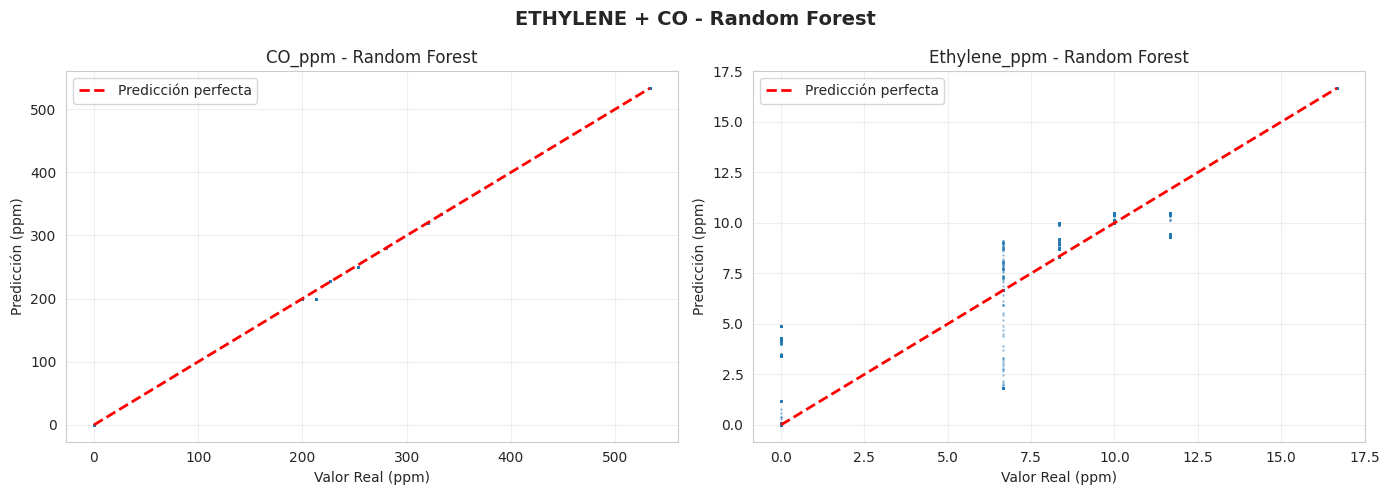

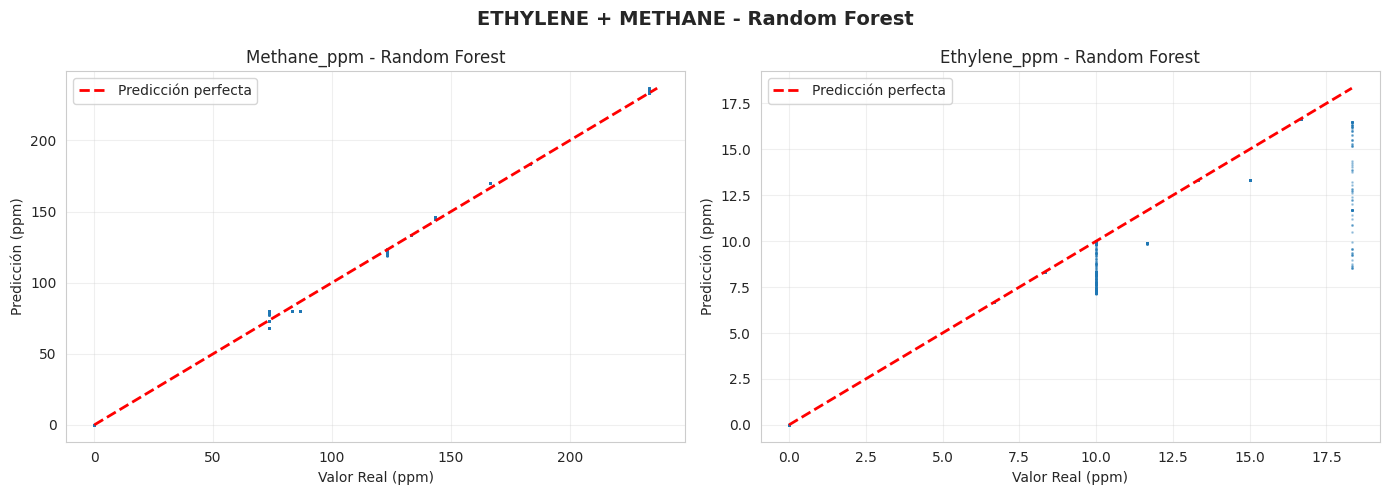

In [53]:
# Celda 39: Visualización de predicciones vs valores reales
print("=" * 70)
print("VISUALIZACIÓN DE PREDICCIONES")
print("=" * 70)

def plot_predictions(y_test, y_pred, target_cols, model_name, dataset_name):
    """
    Visualiza predicciones vs valores reales
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for idx, target in enumerate(target_cols):
        y_true = y_test.iloc[:, idx]
        y_p = y_pred[:, idx]
        
        # Scatter plot
        axes[idx].scatter(y_true, y_p, alpha=0.3, s=1)
        
        # Línea perfecta (y=x)
        min_val = min(y_true.min(), y_p.min())
        max_val = max(y_true.max(), y_p.max())
        axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')
        
        axes[idx].set_xlabel('Valor Real (ppm)')
        axes[idx].set_ylabel('Predicción (ppm)')
        axes[idx].set_title(f'{target} - {model_name}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} - {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualizar mejor modelo para CO (Random Forest)
y_pred_rf_co = model_rf_co.predict(X_test_co)
plot_predictions(y_test_co, y_pred_rf_co, targets_co, 'Random Forest', 'ETHYLENE + CO')

# Visualizar mejor modelo para Methane (Random Forest)
y_pred_rf_methane = model_rf_methane.predict(X_test_methane)
plot_predictions(y_test_methane, y_pred_rf_methane, targets_methane, 'Random Forest', 'ETHYLENE + METHANE')

In [37]:
# Celda 41: Detección de Anomalías - Nivel Señal (Reglas Directas)
print("=" * 70)
print("DETECCIÓN DE ANOMALÍAS - NIVEL SEÑAL")
print("=" * 70)

def detect_signal_anomalies(df, name):
    """
    Detecta anomalías aplicando reglas directas sobre las señales
    - Saturación: valores bloqueados en máximo
    - Flatlines: señal sin variación
    - Picos: valores fuera de rango normal
    - Valores imposibles: negativos o extremadamente altos
    """
    print(f"\n📊 {name}")
    
    sensor_cols = [col for col in df.columns if col.startswith('Sensor_') and 'lag' not in col and 'mean' not in col and 'std' not in col and 'min' not in col and 'max' not in col and 'diff' not in col]
    
    anomalies = {}
    
    for sensor in sensor_cols:
        sensor_data = df[sensor]
        anomalies[sensor] = {
            'saturated': [],
            'flatline': [],
            'spike': [],
            'impossible': []
        }
        
        # 1. Saturación: valores en el percentil 99.9
        saturation_threshold = sensor_data.quantile(0.999)
        saturated_idx = sensor_data[sensor_data >= saturation_threshold].index.tolist()
        anomalies[sensor]['saturated'] = saturated_idx
        
        # 2. Flatlines: ventanas con std muy baja
        window = 100
        rolling_std = sensor_data.rolling(window=window).std()
        flatline_idx = rolling_std[rolling_std < 0.01].index.tolist()
        anomalies[sensor]['flatline'] = flatline_idx
        
        # 3. Picos: valores fuera de 3 desviaciones estándar
        mean = sensor_data.mean()
        std = sensor_data.std()
        spike_idx = sensor_data[(sensor_data > mean + 3*std) | (sensor_data < mean - 3*std)].index.tolist()
        anomalies[sensor]['spike'] = spike_idx
        
        # 4. Valores imposibles: negativos
        impossible_idx = sensor_data[sensor_data < 0].index.tolist()
        anomalies[sensor]['impossible'] = impossible_idx
    
    # Resumen
    print("\nResumen de anomalías detectadas:")
    print(f"{'Sensor':<15} {'Saturación':<12} {'Flatline':<12} {'Picos':<12} {'Imposibles':<12}")
    print("-" * 63)
    
    total_anomalies = {'saturated': 0, 'flatline': 0, 'spike': 0, 'impossible': 0}
    
    for sensor in sensor_cols:
        sat_count = len(anomalies[sensor]['saturated'])
        flat_count = len(anomalies[sensor]['flatline'])
        spike_count = len(anomalies[sensor]['spike'])
        imp_count = len(anomalies[sensor]['impossible'])
        
        print(f"{sensor:<15} {sat_count:<12} {flat_count:<12} {spike_count:<12} {imp_count:<12}")
        
        total_anomalies['saturated'] += sat_count
        total_anomalies['flatline'] += flat_count
        total_anomalies['spike'] += spike_count
        total_anomalies['impossible'] += imp_count
    
    print("-" * 63)
    print(f"{'TOTAL':<15} {total_anomalies['saturated']:<12} {total_anomalies['flatline']:<12} {total_anomalies['spike']:<12} {total_anomalies['impossible']:<12}")
    
    return anomalies, total_anomalies

# Detectar anomalías en ambos datasets
anomalies_co, total_anom_co = detect_signal_anomalies(df_co_clean, "ETHYLENE + CO")
anomalies_methane, total_anom_methane = detect_signal_anomalies(df_methane_clean, "ETHYLENE + METHANE")

print("\n✓ Detección de anomalías a nivel señal completada")

DETECCIÓN DE ANOMALÍAS - NIVEL SEÑAL

📊 ETHYLENE + CO

Resumen de anomalías detectadas:
Sensor          Saturación   Flatline     Picos        Imposibles  
---------------------------------------------------------------
Sensor_01       43           0            0            0           
Sensor_02       43           0            1217         9084        
Sensor_03       43           0            0            0           
Sensor_04       43           0            0            0           
Sensor_05       43           0            0            0           
Sensor_06       43           0            0            0           
Sensor_07       43           0            0            0           
Sensor_08       43           0            0            0           
Sensor_09       43           0            0            0           
Sensor_10       43           0            0            0           
Sensor_11       43           0            0            0           
Sensor_12       43           0  

In [38]:
# Celda 42: Crear etiquetas de anomalías a nivel señal
print("=" * 70)
print("CREACIÓN DE ETIQUETAS DE ANOMALÍAS")
print("=" * 70)

def create_anomaly_labels(df, anomalies):
    """
    Crea una columna binaria indicando si hay anomalía en cada fila
    """
    anomaly_label = np.zeros(len(df), dtype=int)
    
    for sensor, anom_dict in anomalies.items():
        for anom_type, indices in anom_dict.items():
            if len(indices) > 0:
                anomaly_label[indices] = 1
    
    return anomaly_label

# Crear etiquetas
anomaly_labels_co = create_anomaly_labels(df_co_clean, anomalies_co)
anomaly_labels_methane = create_anomaly_labels(df_methane_clean, anomalies_methane)

print(f"\n📊 ETHYLENE + CO:")
print(f"  Total muestras: {len(anomaly_labels_co):,}")
print(f"  Anomalías detectadas: {anomaly_labels_co.sum():,}")
print(f"  Porcentaje: {(anomaly_labels_co.sum() / len(anomaly_labels_co) * 100):.2f}%")

print(f"\n📊 ETHYLENE + METHANE:")
print(f"  Total muestras: {len(anomaly_labels_methane):,}")
print(f"  Anomalías detectadas: {anomaly_labels_methane.sum():,}")
print(f"  Porcentaje: {(anomaly_labels_methane.sum() / len(anomaly_labels_methane) * 100):.2f}%")

print("\n✓ Etiquetas de anomalías creadas")

CREACIÓN DE ETIQUETAS DE ANOMALÍAS

📊 ETHYLENE + CO:
  Total muestras: 42,054
  Anomalías detectadas: 10,549
  Porcentaje: 25.08%

📊 ETHYLENE + METHANE:
  Total muestras: 41,757
  Anomalías detectadas: 445
  Porcentaje: 1.07%

✓ Etiquetas de anomalías creadas


In [39]:
# Celda 43: Calcular residuales del modelo
print("=" * 70)
print("DETECCIÓN DE ANOMALÍAS - NIVEL MODELO (RESIDUALES)")
print("=" * 70)

def calculate_residuals(y_true, y_pred, target_cols):
    """
    Calcula los residuales (errores) del modelo
    """
    residuals = {}
    
    for idx, target in enumerate(target_cols):
        residuals[target] = y_true.iloc[:, idx].values - y_pred[:, idx]
    
    return residuals

# Calcular residuales para el mejor modelo (Random Forest) en test set
print("\n📊 Calculando residuales para ETHYLENE + CO...")
y_pred_test_co = model_rf_co.predict(X_test_co)
residuals_co = calculate_residuals(y_test_co, y_pred_test_co, targets_co)

print(f"  Residuales calculados para: {list(residuals_co.keys())}")

print("\n📊 Calculando residuales para ETHYLENE + METHANE...")
y_pred_test_methane = model_rf_methane.predict(X_test_methane)
residuals_methane = calculate_residuals(y_test_methane, y_pred_test_methane, targets_methane)

print(f"  Residuales calculados para: {list(residuals_methane.keys())}")

# Estadísticas de residuales
print("\n" + "=" * 70)
print("ESTADÍSTICAS DE RESIDUALES")
print("=" * 70)

for target, res in residuals_co.items():
    print(f"\n{target} (CO Dataset):")
    print(f"  Media: {np.mean(res):.4f}")
    print(f"  Std: {np.std(res):.4f}")
    print(f"  Min: {np.min(res):.4f}")
    print(f"  Max: {np.max(res):.4f}")

for target, res in residuals_methane.items():
    print(f"\n{target} (Methane Dataset):")
    print(f"  Media: {np.mean(res):.4f}")
    print(f"  Std: {np.std(res):.4f}")
    print(f"  Min: {np.min(res):.4f}")
    print(f"  Max: {np.max(res):.4f}")

print("\n✓ Residuales calculados")

DETECCIÓN DE ANOMALÍAS - NIVEL MODELO (RESIDUALES)

📊 Calculando residuales para ETHYLENE + CO...
  Residuales calculados para: ['CO_ppm', 'Ethylene_ppm']

📊 Calculando residuales para ETHYLENE + METHANE...
  Residuales calculados para: ['Methane_ppm', 'Ethylene_ppm']

ESTADÍSTICAS DE RESIDUALES

CO_ppm (CO Dataset):
  Media: 0.7442
  Std: 2.0409
  Min: -0.6665
  Max: 13.3300

Ethylene_ppm (CO Dataset):
  Media: -0.3369
  Std: 1.1885
  Min: -4.9000
  Max: 4.8199

Methane_ppm (Methane Dataset):
  Media: -0.0303
  Std: 2.4143
  Min: -6.6367
  Max: 6.6700

Ethylene_ppm (Methane Dataset):
  Media: 0.2593
  Std: 0.8646
  Min: -0.0000
  Max: 9.7944

✓ Residuales calculados


VISUALIZACIÓN DE RESIDUALES


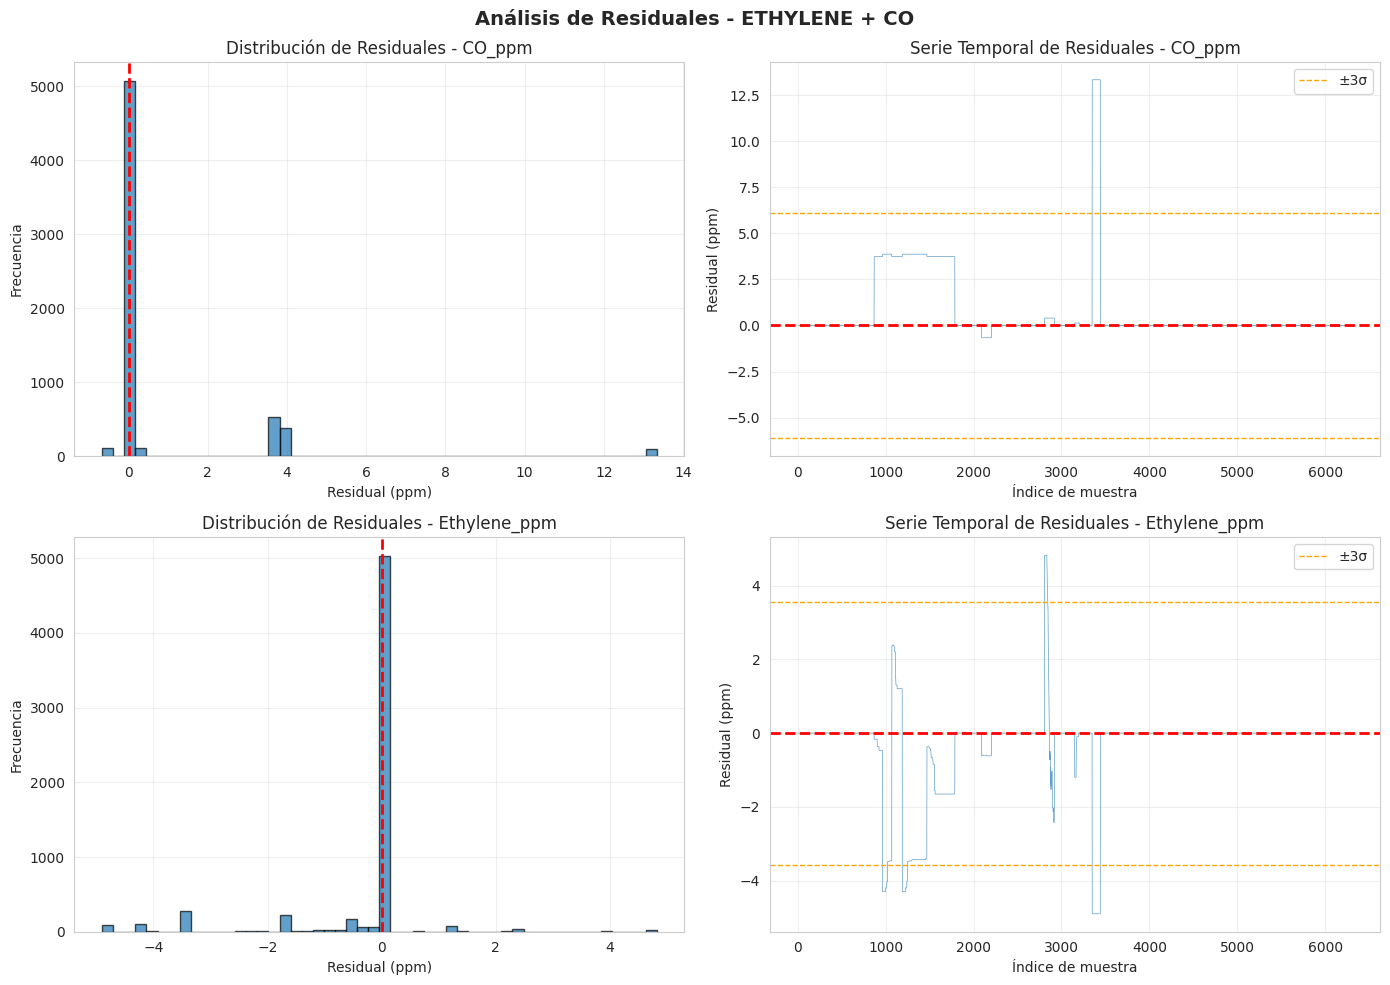

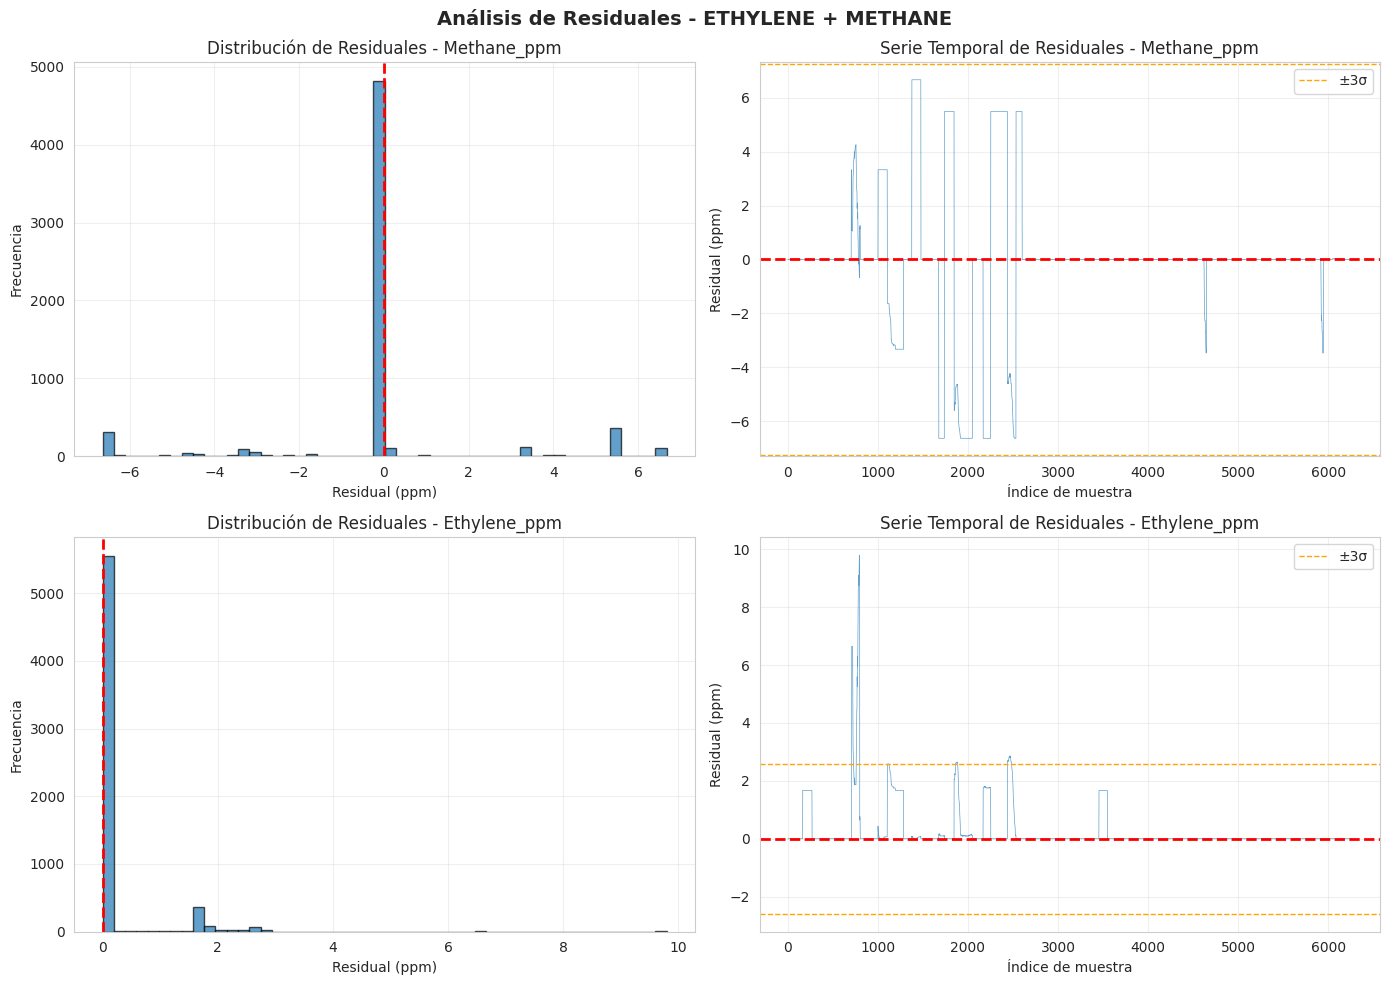

In [40]:
# Celda 44: Visualización de residuales
print("=" * 70)
print("VISUALIZACIÓN DE RESIDUALES")
print("=" * 70)

def plot_residuals(residuals, target_cols, dataset_name):
    """
    Visualiza la distribución de residuales
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    for idx, target in enumerate(target_cols):
        res = residuals[target]
        
        # Histograma
        axes[idx, 0].hist(res, bins=50, edgecolor='black', alpha=0.7)
        axes[idx, 0].set_title(f'Distribución de Residuales - {target}')
        axes[idx, 0].set_xlabel('Residual (ppm)')
        axes[idx, 0].set_ylabel('Frecuencia')
        axes[idx, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Serie temporal de residuales
        axes[idx, 1].plot(res, linewidth=0.5, alpha=0.7)
        axes[idx, 1].set_title(f'Serie Temporal de Residuales - {target}')
        axes[idx, 1].set_xlabel('Índice de muestra')
        axes[idx, 1].set_ylabel('Residual (ppm)')
        axes[idx, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
        
        # Líneas de ±3 std
        std = np.std(res)
        axes[idx, 1].axhline(y=3*std, color='orange', linestyle='--', linewidth=1, label='±3σ')
        axes[idx, 1].axhline(y=-3*std, color='orange', linestyle='--', linewidth=1)
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Análisis de Residuales - {dataset_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualizar residuales
plot_residuals(residuals_co, targets_co, 'ETHYLENE + CO')
plot_residuals(residuals_methane, targets_methane, 'ETHYLENE + METHANE')

In [41]:
# Celda 45: Detección de anomalías con Isolation Forest en residuales
print("=" * 70)
print("DETECCIÓN DE ANOMALÍAS - ISOLATION FOREST EN RESIDUALES")
print("=" * 70)

from sklearn.ensemble import IsolationForest

def detect_anomalies_isolation_forest(residuals, target_cols, contamination=0.05):
    """
    Detecta anomalías en los residuales usando Isolation Forest
    """
    # Combinar residuales en una matriz
    residuals_matrix = np.column_stack([residuals[target] for target in target_cols])
    
    # Entrenar Isolation Forest
    print(f"Entrenando Isolation Forest (contamination={contamination})...")
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    
    # Predecir anomalías (-1 = anomalía, 1 = normal)
    predictions = iso_forest.fit_predict(residuals_matrix)
    
    # Convertir a etiquetas binarias (1 = anomalía, 0 = normal)
    anomaly_labels = (predictions == -1).astype(int)
    
    # Scores de anomalía (más negativo = más anómalo)
    anomaly_scores = iso_forest.score_samples(residuals_matrix)
    
    return anomaly_labels, anomaly_scores, iso_forest

# Detectar anomalías en CO
print("\n📊 ETHYLENE + CO:")
anomaly_labels_iso_co, anomaly_scores_co, iso_model_co = detect_anomalies_isolation_forest(
    residuals_co, targets_co, contamination=0.05
)

print(f"  Total muestras: {len(anomaly_labels_iso_co):,}")
print(f"  Anomalías detectadas: {anomaly_labels_iso_co.sum():,}")
print(f"  Porcentaje: {(anomaly_labels_iso_co.sum() / len(anomaly_labels_iso_co) * 100):.2f}%")

# Detectar anomalías en Methane
print("\n📊 ETHYLENE + METHANE:")
anomaly_labels_iso_methane, anomaly_scores_methane, iso_model_methane = detect_anomalies_isolation_forest(
    residuals_methane, targets_methane, contamination=0.05
)

print(f"  Total muestras: {len(anomaly_labels_iso_methane):,}")
print(f"  Anomalías detectadas: {anomaly_labels_iso_methane.sum():,}")
print(f"  Porcentaje: {(anomaly_labels_iso_methane.sum() / len(anomaly_labels_iso_methane) * 100):.2f}%")

print("\n✓ Detección con Isolation Forest completada")

DETECCIÓN DE ANOMALÍAS - ISOLATION FOREST EN RESIDUALES

📊 ETHYLENE + CO:
Entrenando Isolation Forest (contamination=0.05)...
  Total muestras: 6,309
  Anomalías detectadas: 258
  Porcentaje: 4.09%

📊 ETHYLENE + METHANE:
Entrenando Isolation Forest (contamination=0.05)...
  Total muestras: 6,264
  Anomalías detectadas: 314
  Porcentaje: 5.01%

✓ Detección con Isolation Forest completada


In [42]:
# Celda 45: Detección de anomalías con Isolation Forest en residuales
print("=" * 70)
print("DETECCIÓN DE ANOMALÍAS - ISOLATION FOREST EN RESIDUALES")
print("=" * 70)

from sklearn.ensemble import IsolationForest

def detect_anomalies_isolation_forest(residuals, target_cols, contamination=0.05):
    """
    Detecta anomalías en los residuales usando Isolation Forest
    """
    # Combinar residuales en una matriz
    residuals_matrix = np.column_stack([residuals[target] for target in target_cols])
    
    # Entrenar Isolation Forest
    print(f"Entrenando Isolation Forest (contamination={contamination})...")
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    
    # Predecir anomalías (-1 = anomalía, 1 = normal)
    predictions = iso_forest.fit_predict(residuals_matrix)
    
    # Convertir a etiquetas binarias (1 = anomalía, 0 = normal)
    anomaly_labels = (predictions == -1).astype(int)
    
    # Scores de anomalía (más negativo = más anómalo)
    anomaly_scores = iso_forest.score_samples(residuals_matrix)
    
    return anomaly_labels, anomaly_scores, iso_forest

# Detectar anomalías en CO
print("\n📊 ETHYLENE + CO:")
anomaly_labels_iso_co, anomaly_scores_co, iso_model_co = detect_anomalies_isolation_forest(
    residuals_co, targets_co, contamination=0.05
)

print(f"  Total muestras: {len(anomaly_labels_iso_co):,}")
print(f"  Anomalías detectadas: {anomaly_labels_iso_co.sum():,}")
print(f"  Porcentaje: {(anomaly_labels_iso_co.sum() / len(anomaly_labels_iso_co) * 100):.2f}%")

# Detectar anomalías en Methane
print("\n📊 ETHYLENE + METHANE:")
anomaly_labels_iso_methane, anomaly_scores_methane, iso_model_methane = detect_anomalies_isolation_forest(
    residuals_methane, targets_methane, contamination=0.05
)

print(f"  Total muestras: {len(anomaly_labels_iso_methane):,}")
print(f"  Anomalías detectadas: {anomaly_labels_iso_methane.sum():,}")
print(f"  Porcentaje: {(anomaly_labels_iso_methane.sum() / len(anomaly_labels_iso_methane) * 100):.2f}%")

print("\n✓ Detección con Isolation Forest completada")

DETECCIÓN DE ANOMALÍAS - ISOLATION FOREST EN RESIDUALES

📊 ETHYLENE + CO:
Entrenando Isolation Forest (contamination=0.05)...
  Total muestras: 6,309
  Anomalías detectadas: 258
  Porcentaje: 4.09%

📊 ETHYLENE + METHANE:
Entrenando Isolation Forest (contamination=0.05)...
  Total muestras: 6,264
  Anomalías detectadas: 314
  Porcentaje: 5.01%

✓ Detección con Isolation Forest completada


ANÁLISIS DE ANOMALÍAS POR CONDICIÓN OPERATIVA

📊 ETHYLENE + CO

Distribución de anomalías por condición:
           Anomalías  Total      Tasa   Tasa (%)
condition                                       
Gas Puro         105   5552  0.018912   1.891210
Mezcla           153    757  0.202114  20.211361


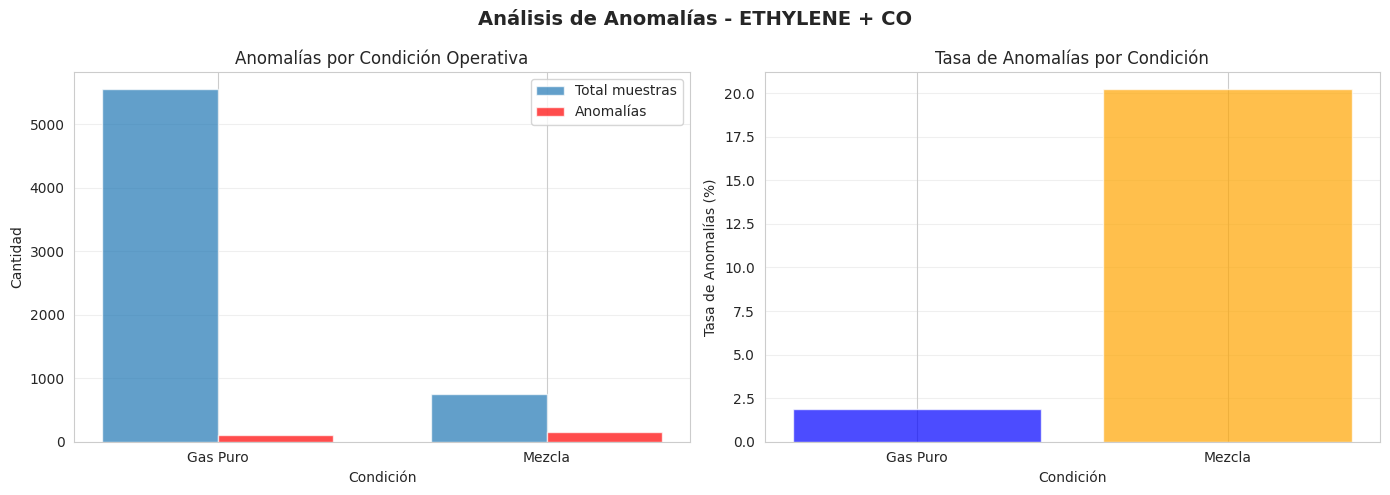


📊 ETHYLENE + METHANE

Distribución de anomalías por condición:
           Anomalías  Total      Tasa   Tasa (%)
condition                                       
Gas Puro           0   5220  0.000000   0.000000
Mezcla           314   1044  0.300766  30.076628


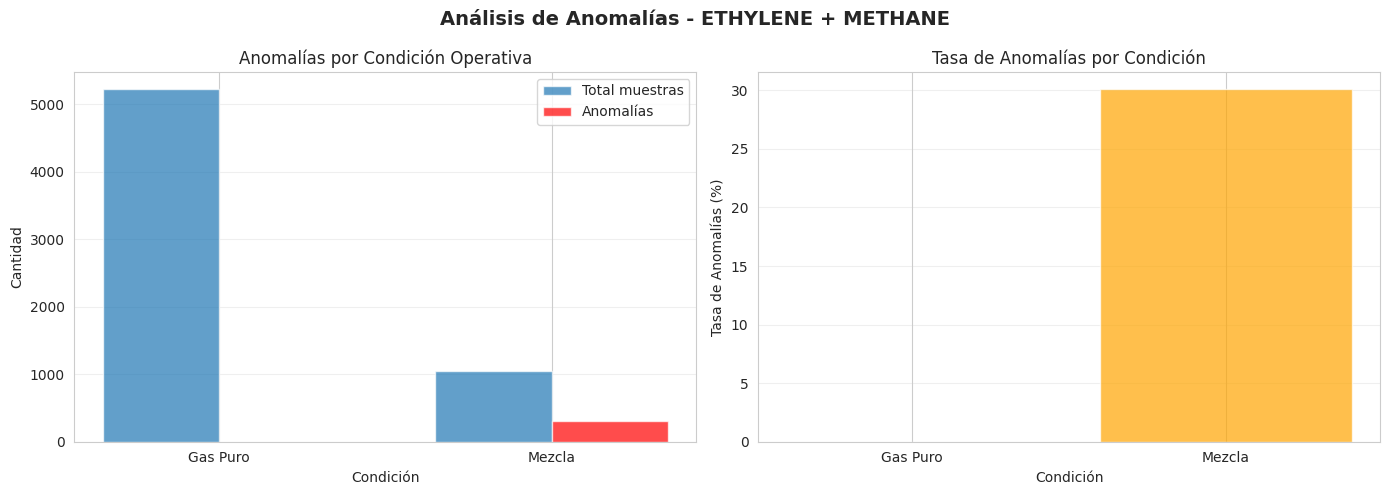

In [43]:
# Celda 47: Análisis de anomalías en diferentes condiciones
print("=" * 70)
print("ANÁLISIS DE ANOMALÍAS POR CONDICIÓN OPERATIVA")
print("=" * 70)

def analyze_anomalies_by_condition(df, anomaly_labels, gas1_col, gas2_col, dataset_name):
    """
    Analiza cómo se distribuyen las anomalías en diferentes condiciones
    """
    print(f"\n📊 {dataset_name}")
    
    # Obtener índices del test set
    n_total = len(df)
    test_start = int(n_total * 0.85)  # 70% train + 15% val = 85%
    
    df_test = df.iloc[test_start:].copy()
    df_test = df_test.iloc[:len(anomaly_labels)].copy()  # Asegurar mismo tamaño
    
    # Añadir etiquetas de anomalía
    df_test['anomaly'] = anomaly_labels
    
    # Identificar condiciones
    df_test['condition'] = 'Mezcla'
    df_test.loc[(df_test[gas1_col] == 0) | (df_test[gas2_col] == 0), 'condition'] = 'Gas Puro'
    
    # Analizar por condición
    print("\nDistribución de anomalías por condición:")
    condition_analysis = df_test.groupby('condition')['anomaly'].agg(['sum', 'count', 'mean'])
    condition_analysis.columns = ['Anomalías', 'Total', 'Tasa']
    condition_analysis['Tasa (%)'] = condition_analysis['Tasa'] * 100
    
    print(condition_analysis)
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de barras
    conditions = condition_analysis.index
    anomaly_counts = condition_analysis['Anomalías']
    total_counts = condition_analysis['Total']
    
    x = np.arange(len(conditions))
    width = 0.35
    
    axes[0].bar(x - width/2, total_counts, width, label='Total muestras', alpha=0.7)
    axes[0].bar(x + width/2, anomaly_counts, width, label='Anomalías', alpha=0.7, color='red')
    axes[0].set_xlabel('Condición')
    axes[0].set_ylabel('Cantidad')
    axes[0].set_title('Anomalías por Condición Operativa')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(conditions)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Tasa de anomalías
    axes[1].bar(conditions, condition_analysis['Tasa (%)'], color=['blue', 'orange'], alpha=0.7)
    axes[1].set_xlabel('Condición')
    axes[1].set_ylabel('Tasa de Anomalías (%)')
    axes[1].set_title('Tasa de Anomalías por Condición')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Análisis de Anomalías - {dataset_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Analizar ambos datasets
analyze_anomalies_by_condition(df_co_clean, anomaly_labels_iso_co, 
                                'CO_ppm', 'Ethylene_ppm', 'ETHYLENE + CO')
analyze_anomalies_by_condition(df_methane_clean, anomaly_labels_iso_methane, 
                                'Methane_ppm', 'Ethylene_ppm', 'ETHYLENE + METHANE')

In [44]:
# Celda 49: Simulación de fallos aleatorios en sensores
print("=" * 70)
print("ROBUSTEZ Y REDUNDANCIA - SIMULACIÓN DE FALLOS")
print("=" * 70)

def simulate_sensor_failures(X, failure_rate, seed=42):
    """
    Simula fallos aleatorios en sensores estableciendo sus valores a NaN
    
    Parameters:
    - X: DataFrame de features
    - failure_rate: porcentaje de sensores a fallar (0.1 = 10%, 0.3 = 30%)
    - seed: semilla aleatoria
    """
    np.random.seed(seed)
    X_failed = X.copy()
    
    # Identificar solo columnas de sensores originales (sin lags, sin agregados)
    sensor_cols = [col for col in X.columns if col.startswith('Sensor_') 
                   and 'lag' not in col and 'mean' not in col and 'std' not in col 
                   and 'min' not in col and 'max' not in col and 'diff' not in col]
    
    n_sensors = len(sensor_cols)
    n_failures = int(n_sensors * failure_rate)
    
    # Seleccionar sensores a fallar aleatoriamente
    failed_sensors = np.random.choice(sensor_cols, size=n_failures, replace=False)
    
    # Establecer valores a NaN para simular fallo
    for sensor in failed_sensors:
        X_failed[sensor] = np.nan
    
    return X_failed, failed_sensors

print("Función de simulación de fallos definida")

ROBUSTEZ Y REDUNDANCIA - SIMULACIÓN DE FALLOS
Función de simulación de fallos definida


In [45]:
# Celda 50: Evaluación de robustez con diferentes tasas de fallo
print("=" * 70)
print("EVALUACIÓN DE ROBUSTEZ CON DIFERENTES TASAS DE FALLO")
print("=" * 70)

def evaluate_robustness(model, X_test, y_test, target_cols, failure_rates, dataset_name, n_trials=5):
    """
    Evalúa cómo se degrada el rendimiento con diferentes tasas de fallo
    
    Parameters:
    - model: modelo entrenado
    - X_test: datos de test
    - y_test: targets de test
    - target_cols: nombres de columnas target
    - failure_rates: lista de tasas de fallo a probar
    - dataset_name: nombre del dataset
    - n_trials: número de simulaciones por tasa
    """
    print(f"\n📊 {dataset_name}")
    print(f"Probando tasas de fallo: {failure_rates}")
    print(f"Trials por tasa: {n_trials}")
    
    results = {
        'failure_rate': [],
        'trial': [],
    }
    
    for target in target_cols:
        results[f'{target}_MAE'] = []
        results[f'{target}_RMSE'] = []
        results[f'{target}_R2'] = []
    
    # Baseline sin fallos
    print("\nBaseline (sin fallos):")
    y_pred_baseline = model.predict(X_test.fillna(0))  # Llenar NaN con 0 por si acaso
    baseline_metrics = evaluate_model(y_test, y_pred_baseline, target_cols)
    print_metrics(baseline_metrics, "Baseline")
    
    # Evaluar cada tasa de fallo
    for failure_rate in failure_rates:
        print(f"\n{'='*60}")
        print(f"Tasa de fallo: {failure_rate*100:.0f}%")
        print(f"{'='*60}")
        
        for trial in range(n_trials):
            # Simular fallos
            X_test_failed, failed_sensors = simulate_sensor_failures(X_test, failure_rate, seed=42+trial)
            
            # Reemplazar NaN con 0 (estrategia simple de imputación)
            X_test_imputed = X_test_failed.fillna(0)
            
            # Predecir
            y_pred = model.predict(X_test_imputed)
            
            # Calcular métricas
            metrics = evaluate_model(y_test, y_pred, target_cols)
            
            # Guardar resultados
            results['failure_rate'].append(failure_rate)
            results['trial'].append(trial)
            
            for target in target_cols:
                results[f'{target}_MAE'].append(metrics[target]['MAE'])
                results[f'{target}_RMSE'].append(metrics[target]['RMSE'])
                results[f'{target}_R2'].append(metrics[target]['R2'])
            
            if trial == 0:
                print(f"\nTrial {trial + 1} - Sensores fallados: {list(failed_sensors)}")
                print_metrics(metrics, f"Trial {trial + 1}")
    
    return pd.DataFrame(results), baseline_metrics

# Configurar tasas de fallo a probar
FAILURE_RATES = [0.1, 0.2, 0.3]  # 10%, 20%, 30%
N_TRIALS = 5

# Evaluar robustez para CO
print("\n" + "="*70)
results_robustness_co, baseline_co = evaluate_robustness(
    model_rf_co, X_test_co, y_test_co, targets_co, 
    FAILURE_RATES, "ETHYLENE + CO", N_TRIALS
)

# Evaluar robustez para Methane
print("\n" + "="*70)
results_robustness_methane, baseline_methane = evaluate_robustness(
    model_rf_methane, X_test_methane, y_test_methane, targets_methane, 
    FAILURE_RATES, "ETHYLENE + METHANE", N_TRIALS
)

print("\n✓ Evaluación de robustez completada")

EVALUACIÓN DE ROBUSTEZ CON DIFERENTES TASAS DE FALLO


📊 ETHYLENE + CO
Probando tasas de fallo: [0.1, 0.2, 0.3]
Trials por tasa: 5

Baseline (sin fallos):

Baseline Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 0.7678 ppm
  RMSE: 2.1724 ppm
  R²: 0.9998
  MAE normalizado: 0.14% del rango

Ethylene_ppm:
  MAE: 0.4620 ppm
  RMSE: 1.2353 ppm
  R²: 0.9360
  MAE normalizado: 2.77% del rango

Tasa de fallo: 10%

Trial 1 - Sensores fallados: [np.str_('Sensor_01')]

Trial 1 Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 0.7678 ppm
  RMSE: 2.1724 ppm
  R²: 0.9998
  MAE normalizado: 0.14% del rango

Ethylene_ppm:
  MAE: 0.4620 ppm
  RMSE: 1.2353 ppm
  R²: 0.9360
  MAE normalizado: 2.77% del rango

Tasa de fallo: 20%

Trial 1 - Sensores fallados: [np.str_('Sensor_01'), np.str_('Sensor_02'), np.str_('Sensor_06')]

Trial 1 Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 0.7678 ppm
  

VISUALIZACIÓN DE DEGRADACIÓN DEL RENDIMIENTO


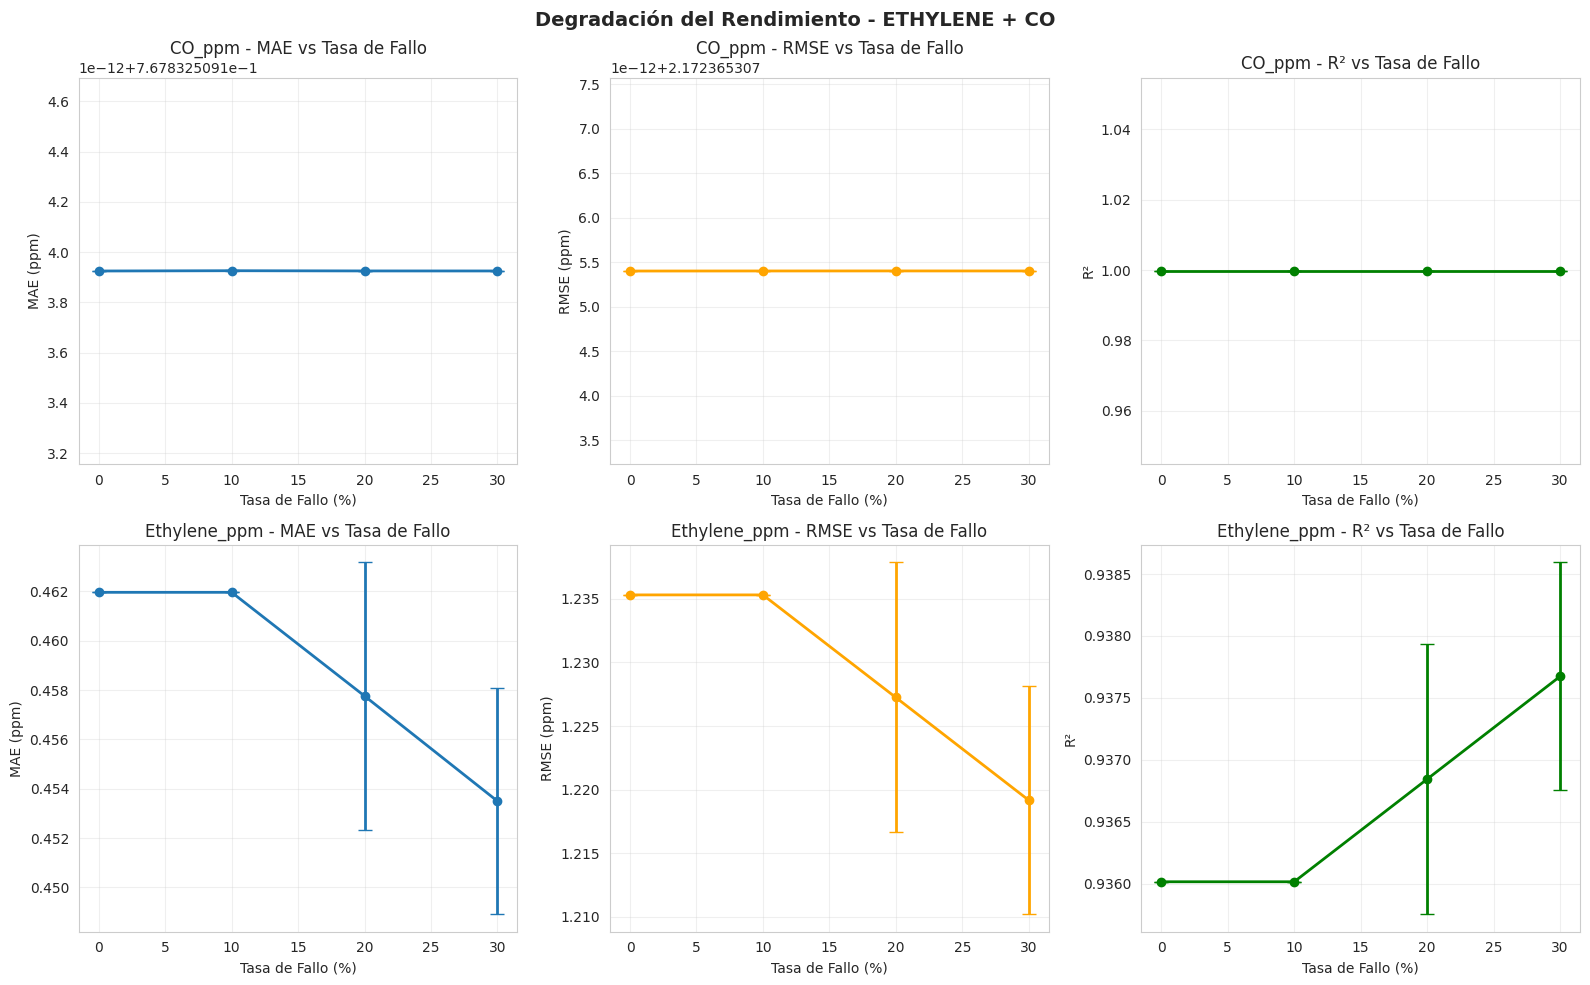

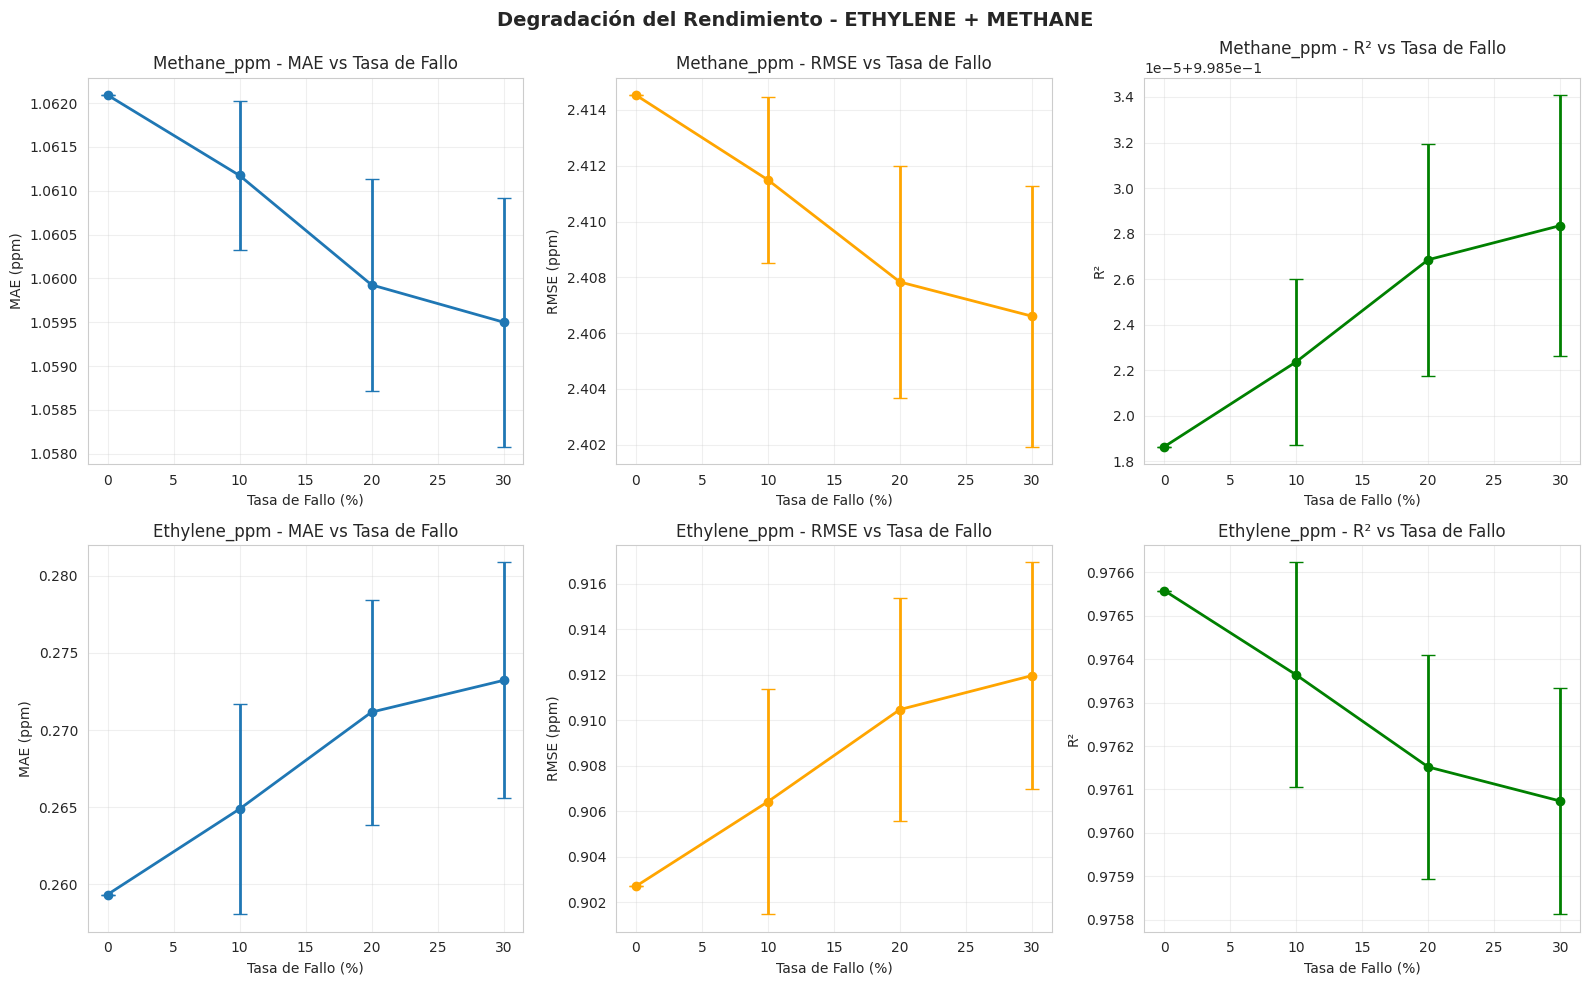

In [46]:
# Celda 51: Visualización de degradación del rendimiento
print("=" * 70)
print("VISUALIZACIÓN DE DEGRADACIÓN DEL RENDIMIENTO")
print("=" * 70)

def plot_robustness_results(results_df, baseline_metrics, target_cols, dataset_name):
    """
    Visualiza cómo se degrada el rendimiento con diferentes tasas de fallo
    """
    fig, axes = plt.subplots(len(target_cols), 3, figsize=(16, 10))
    
    if len(target_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, target in enumerate(target_cols):
        # Agrupar por tasa de fallo
        grouped = results_df.groupby('failure_rate')
        
        failure_rates = []
        mae_means = []
        mae_stds = []
        rmse_means = []
        rmse_stds = []
        r2_means = []
        r2_stds = []
        
        for rate, group in grouped:
            failure_rates.append(rate * 100)
            mae_means.append(group[f'{target}_MAE'].mean())
            mae_stds.append(group[f'{target}_MAE'].std())
            rmse_means.append(group[f'{target}_RMSE'].mean())
            rmse_stds.append(group[f'{target}_RMSE'].std())
            r2_means.append(group[f'{target}_R2'].mean())
            r2_stds.append(group[f'{target}_R2'].std())
        
        # Añadir baseline (0% fallo)
        failure_rates_with_baseline = [0] + failure_rates
        mae_means_with_baseline = [baseline_metrics[target]['MAE']] + mae_means
        mae_stds_with_baseline = [0] + mae_stds
        rmse_means_with_baseline = [baseline_metrics[target]['RMSE']] + rmse_means
        rmse_stds_with_baseline = [0] + rmse_stds
        r2_means_with_baseline = [baseline_metrics[target]['R2']] + r2_means
        r2_stds_with_baseline = [0] + r2_stds
        
        # Plot MAE
        axes[idx, 0].errorbar(failure_rates_with_baseline, mae_means_with_baseline, 
                              yerr=mae_stds_with_baseline, marker='o', capsize=5, linewidth=2)
        axes[idx, 0].set_title(f'{target} - MAE vs Tasa de Fallo')
        axes[idx, 0].set_xlabel('Tasa de Fallo (%)')
        axes[idx, 0].set_ylabel('MAE (ppm)')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Plot RMSE
        axes[idx, 1].errorbar(failure_rates_with_baseline, rmse_means_with_baseline, 
                              yerr=rmse_stds_with_baseline, marker='o', capsize=5, linewidth=2, color='orange')
        axes[idx, 1].set_title(f'{target} - RMSE vs Tasa de Fallo')
        axes[idx, 1].set_xlabel('Tasa de Fallo (%)')
        axes[idx, 1].set_ylabel('RMSE (ppm)')
        axes[idx, 1].grid(True, alpha=0.3)
        
        # Plot R²
        axes[idx, 2].errorbar(failure_rates_with_baseline, r2_means_with_baseline, 
                              yerr=r2_stds_with_baseline, marker='o', capsize=5, linewidth=2, color='green')
        axes[idx, 2].set_title(f'{target} - R² vs Tasa de Fallo')
        axes[idx, 2].set_xlabel('Tasa de Fallo (%)')
        axes[idx, 2].set_ylabel('R²')
        axes[idx, 2].grid(True, alpha=0.3)
    
    plt.suptitle(f'Degradación del Rendimiento - {dataset_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualizar resultados
plot_robustness_results(results_robustness_co, baseline_co, targets_co, 'ETHYLENE + CO')
plot_robustness_results(results_robustness_methane, baseline_methane, targets_methane, 'ETHYLENE + METHANE')

In [47]:
# Celda 52: Análisis de redundancia - Agregación por tipo de sensor
print("=" * 70)
print("ANÁLISIS DE REDUNDANCIA - AGREGACIÓN POR TIPO DE SENSOR")
print("=" * 70)

def create_aggregated_features(df, aggregation='median'):
    """
    Crea features agregadas por tipo de sensor
    
    Parameters:
    - df: DataFrame con features
    - aggregation: tipo de agregación ('median', 'mean', 'max', 'min')
    """
    df_agg = df.copy()
    
    # Agrupar sensores por tipo
    sensor_types = {
        'TGS-2600': ['Sensor_01', 'Sensor_02', 'Sensor_03', 'Sensor_04'],
        'TGS-2602': ['Sensor_05', 'Sensor_06', 'Sensor_07', 'Sensor_08'],
        'TGS-2610': ['Sensor_09', 'Sensor_10', 'Sensor_11', 'Sensor_12'],
        'TGS-2620': ['Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16']
    }
    
    for sensor_type, sensors in sensor_types.items():
        # Verificar que los sensores existan
        existing_sensors = [s for s in sensors if s in df.columns]
        
        if len(existing_sensors) > 0:
            if aggregation == 'median':
                df_agg[f'{sensor_type}_agg'] = df[existing_sensors].median(axis=1)
            elif aggregation == 'mean':
                df_agg[f'{sensor_type}_agg'] = df[existing_sensors].mean(axis=1)
            elif aggregation == 'max':
                df_agg[f'{sensor_type}_agg'] = df[existing_sensors].max(axis=1)
            elif aggregation == 'min':
                df_agg[f'{sensor_type}_agg'] = df[existing_sensors].min(axis=1)
    
    return df_agg

print("Función de agregación definida")

ANÁLISIS DE REDUNDANCIA - AGREGACIÓN POR TIPO DE SENSOR
Función de agregación definida


In [48]:
# Celda 53: Comparación: sensores individuales vs agregados
print("=" * 70)
print("COMPARACIÓN: SENSORES INDIVIDUALES VS AGREGADOS")
print("=" * 70)

def compare_individual_vs_aggregated(X_train, y_train, X_test, y_test, target_cols, dataset_name):
    """
    Compara el rendimiento usando sensores individuales vs agregados por tipo
    """
    print(f"\n📊 {dataset_name}")
    
    # Modelo 1: Solo sensores individuales (ya entrenado anteriormente)
    # Usaremos el modelo Random Forest existente
    
    # Modelo 2: Sensores agregados por tipo
    print("\nCreando features agregadas...")
    X_train_agg = create_aggregated_features(X_train, aggregation='median')
    X_test_agg = create_aggregated_features(X_test, aggregation='median')
    
    # Seleccionar solo features agregadas + contexto
    agg_cols = [col for col in X_train_agg.columns if '_agg' in col or col in ['gas_type', 'pure_gas', 'total_concentration']]
    
    print(f"Features individuales: {X_train.shape[1]}")
    print(f"Features agregadas: {len(agg_cols)}")
    
    # Entrenar modelo con features agregadas
    print("\nEntrenando modelo con features agregadas...")
    model_agg = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    model_agg.fit(X_train_agg[agg_cols], y_train)
    
    # Predicciones
    y_pred_agg = model_agg.predict(X_test_agg[agg_cols])
    
    # Evaluación
    metrics_agg = evaluate_model(y_test, y_pred_agg, target_cols)
    
    print("\nResultados con features agregadas:")
    print_metrics(metrics_agg, "Test")
    
    return model_agg, metrics_agg, agg_cols

# Comparar para ambos datasets
print("\n" + "="*70)
model_agg_co, metrics_agg_co, agg_cols_co = compare_individual_vs_aggregated(
    X_train_co, y_train_co, X_test_co, y_test_co, targets_co, "ETHYLENE + CO"
)

print("\n" + "="*70)
model_agg_methane, metrics_agg_methane, agg_cols_methane = compare_individual_vs_aggregated(
    X_train_methane, y_train_methane, X_test_methane, y_test_methane, targets_methane, "ETHYLENE + METHANE"
)

COMPARACIÓN: SENSORES INDIVIDUALES VS AGREGADOS


📊 ETHYLENE + CO

Creando features agregadas...
Features individuales: 307
Features agregadas: 7

Entrenando modelo con features agregadas...

Resultados con features agregadas:

Test Metrics:
------------------------------------------------------------

CO_ppm:
  MAE: 0.2108 ppm
  RMSE: 1.6220 ppm
  R²: 0.9999
  MAE normalizado: 0.04% del rango

Ethylene_ppm:
  MAE: 0.2469 ppm
  RMSE: 0.7925 ppm
  R²: 0.9737
  MAE normalizado: 1.48% del rango


📊 ETHYLENE + METHANE

Creando features agregadas...
Features individuales: 307
Features agregadas: 7

Entrenando modelo con features agregadas...

Resultados con features agregadas:

Test Metrics:
------------------------------------------------------------

Methane_ppm:
  MAE: 0.7545 ppm
  RMSE: 1.9571 ppm
  R²: 0.9990
  MAE normalizado: 0.32% del rango

Ethylene_ppm:
  MAE: 0.5444 ppm
  RMSE: 1.7424 ppm
  R²: 0.9127
  MAE normalizado: 2.97% del rango


VISUALIZACIÓN: INDIVIDUAL VS AGREGADO


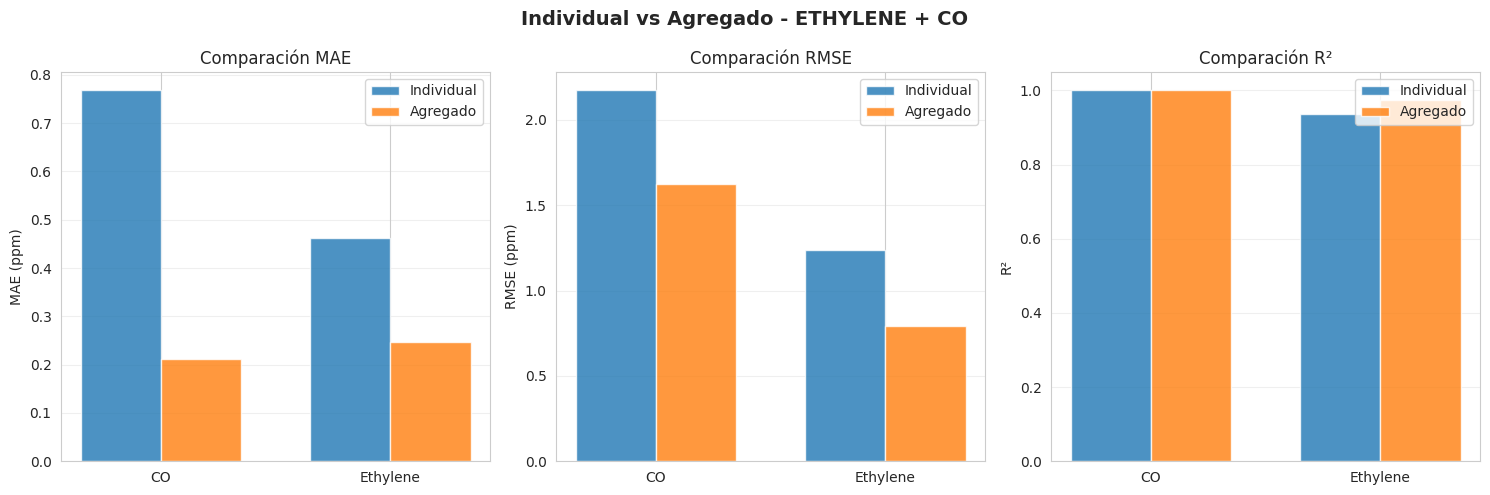

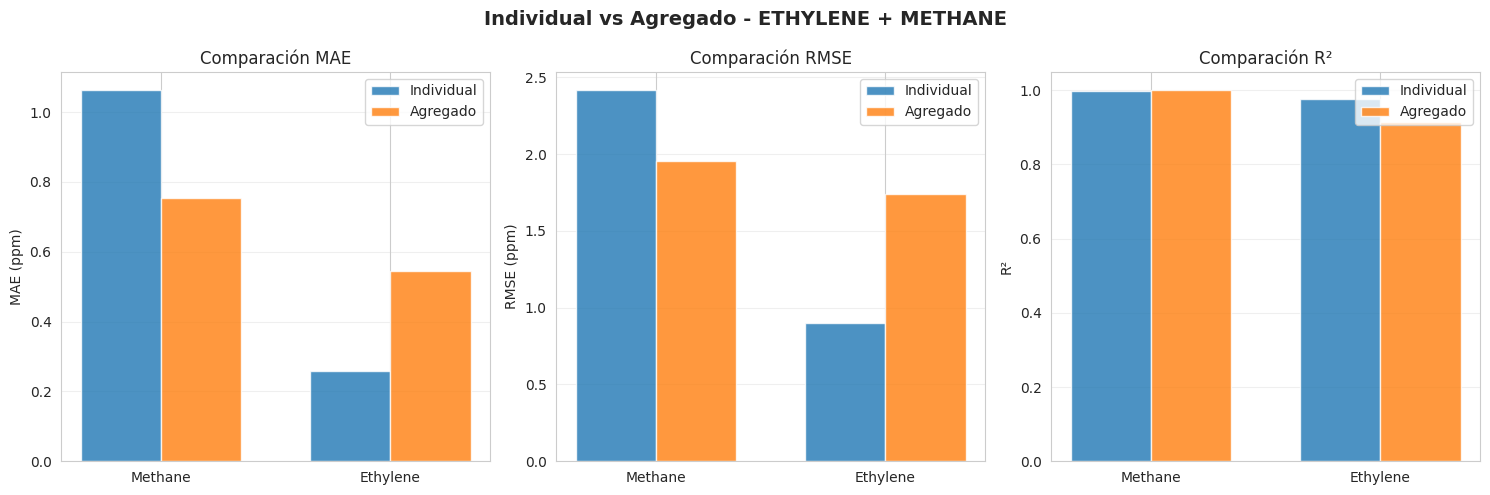

In [49]:
# Celda 54: Visualización de comparación individual vs agregado
print("=" * 70)
print("VISUALIZACIÓN: INDIVIDUAL VS AGREGADO")
print("=" * 70)

def plot_individual_vs_aggregated(metrics_individual, metrics_aggregated, target_cols, dataset_name):
    """
    Visualiza la comparación entre modelos con features individuales vs agregadas
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Preparar datos
    targets = []
    mae_individual = []
    mae_aggregated = []
    rmse_individual = []
    rmse_aggregated = []
    r2_individual = []
    r2_aggregated = []
    
    for target in target_cols:
        targets.append(target.replace('_ppm', ''))
        mae_individual.append(metrics_individual[target]['MAE'])
        mae_aggregated.append(metrics_aggregated[target]['MAE'])
        rmse_individual.append(metrics_individual[target]['RMSE'])
        rmse_aggregated.append(metrics_aggregated[target]['RMSE'])
        r2_individual.append(metrics_individual[target]['R2'])
        r2_aggregated.append(metrics_aggregated[target]['R2'])
    
    x = np.arange(len(targets))
    width = 0.35
    
    # MAE
    axes[0].bar(x - width/2, mae_individual, width, label='Individual', alpha=0.8)
    axes[0].bar(x + width/2, mae_aggregated, width, label='Agregado', alpha=0.8)
    axes[0].set_ylabel('MAE (ppm)')
    axes[0].set_title('Comparación MAE')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(targets)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # RMSE
    axes[1].bar(x - width/2, rmse_individual, width, label='Individual', alpha=0.8)
    axes[1].bar(x + width/2, rmse_aggregated, width, label='Agregado', alpha=0.8)
    axes[1].set_ylabel('RMSE (ppm)')
    axes[1].set_title('Comparación RMSE')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(targets)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # R²
    axes[2].bar(x - width/2, r2_individual, width, label='Individual', alpha=0.8)
    axes[2].bar(x + width/2, r2_aggregated, width, label='Agregado', alpha=0.8)
    axes[2].set_ylabel('R²')
    axes[2].set_title('Comparación R²')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(targets)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle(f'Individual vs Agregado - {dataset_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualizar comparaciones (usando métricas del Random Forest original)
plot_individual_vs_aggregated(metrics_rf_co, metrics_agg_co, targets_co, 'ETHYLENE + CO')
plot_individual_vs_aggregated(metrics_rf_methane, metrics_agg_methane, targets_methane, 'ETHYLENE + METHANE')

In [50]:
# Celda 55: Robustez del modelo agregado ante fallos
print("=" * 70)
print("ROBUSTEZ DEL MODELO AGREGADO ANTE FALLOS")
print("=" * 70)

def evaluate_aggregated_robustness(model_agg, X_test, y_test, target_cols, agg_cols, 
                                   failure_rates, dataset_name, n_trials=5):
    """
    Evalúa la robustez del modelo con features agregadas
    """
    print(f"\n📊 {dataset_name}")
    
    # Crear features agregadas para test
    X_test_agg = create_aggregated_features(X_test, aggregation='median')
    
    results = {
        'failure_rate': [],
        'trial': [],
    }
    
    for target in target_cols:
        results[f'{target}_MAE'] = []
        results[f'{target}_RMSE'] = []
        results[f'{target}_R2'] = []
    
    # Baseline
    y_pred_baseline = model_agg.predict(X_test_agg[agg_cols].fillna(0))
    baseline_metrics = evaluate_model(y_test, y_pred_baseline, target_cols)
    
    # Evaluar con fallos
    for failure_rate in failure_rates:
        print(f"\nTasa de fallo: {failure_rate*100:.0f}%")
        
        for trial in range(n_trials):
            # Simular fallos en sensores originales
            X_test_failed, _ = simulate_sensor_failures(X_test, failure_rate, seed=42+trial)
            
            # Recrear agregados (la agregación ayuda a mitigar fallos)
            X_test_failed_agg = create_aggregated_features(X_test_failed, aggregation='median')
            X_test_imputed = X_test_failed_agg[agg_cols].fillna(0)
            
            # Predecir
            y_pred = model_agg.predict(X_test_imputed)
            
            # Métricas
            metrics = evaluate_model(y_test, y_pred, target_cols)
            
            results['failure_rate'].append(failure_rate)
            results['trial'].append(trial)
            
            for target in target_cols:
                results[f'{target}_MAE'].append(metrics[target]['MAE'])
                results[f'{target}_RMSE'].append(metrics[target]['RMSE'])
                results[f'{target}_R2'].append(metrics[target]['R2'])
    
    return pd.DataFrame(results), baseline_metrics

# Evaluar robustez de modelos agregados
print("\n" + "="*70)
results_agg_robustness_co, baseline_agg_co = evaluate_aggregated_robustness(
    model_agg_co, X_test_co, y_test_co, targets_co, agg_cols_co,
    FAILURE_RATES, "ETHYLENE + CO (Agregado)", N_TRIALS
)

print("\n" + "="*70)
results_agg_robustness_methane, baseline_agg_methane = evaluate_aggregated_robustness(
    model_agg_methane, X_test_methane, y_test_methane, targets_methane, agg_cols_methane,
    FAILURE_RATES, "ETHYLENE + METHANE (Agregado)", N_TRIALS
)

print("\n✓ Evaluación de robustez de modelos agregados completada")

ROBUSTEZ DEL MODELO AGREGADO ANTE FALLOS


📊 ETHYLENE + CO (Agregado)

Tasa de fallo: 10%

Tasa de fallo: 20%

Tasa de fallo: 30%


📊 ETHYLENE + METHANE (Agregado)

Tasa de fallo: 10%

Tasa de fallo: 20%

Tasa de fallo: 30%

✓ Evaluación de robustez de modelos agregados completada


COMPARACIÓN DE ROBUSTEZ: INDIVIDUAL VS AGREGADO

CO_ppm:
  Reducción de variabilidad promedio: -5388733747876412.00%
  Tasa 10%: Reducción = -3709347052241579.00%
  Tasa 20%: Reducción = -7334029478104361.00%
  Tasa 30%: Reducción = -5122824713283297.00%

Ethylene_ppm:
  Reducción de variabilidad promedio: -40127923180717336.00%
  Tasa 10%: Reducción = -120383769542147696.00%
  Tasa 20%: Reducción = -2000.18%
  Tasa 30%: Reducción = -2320.54%


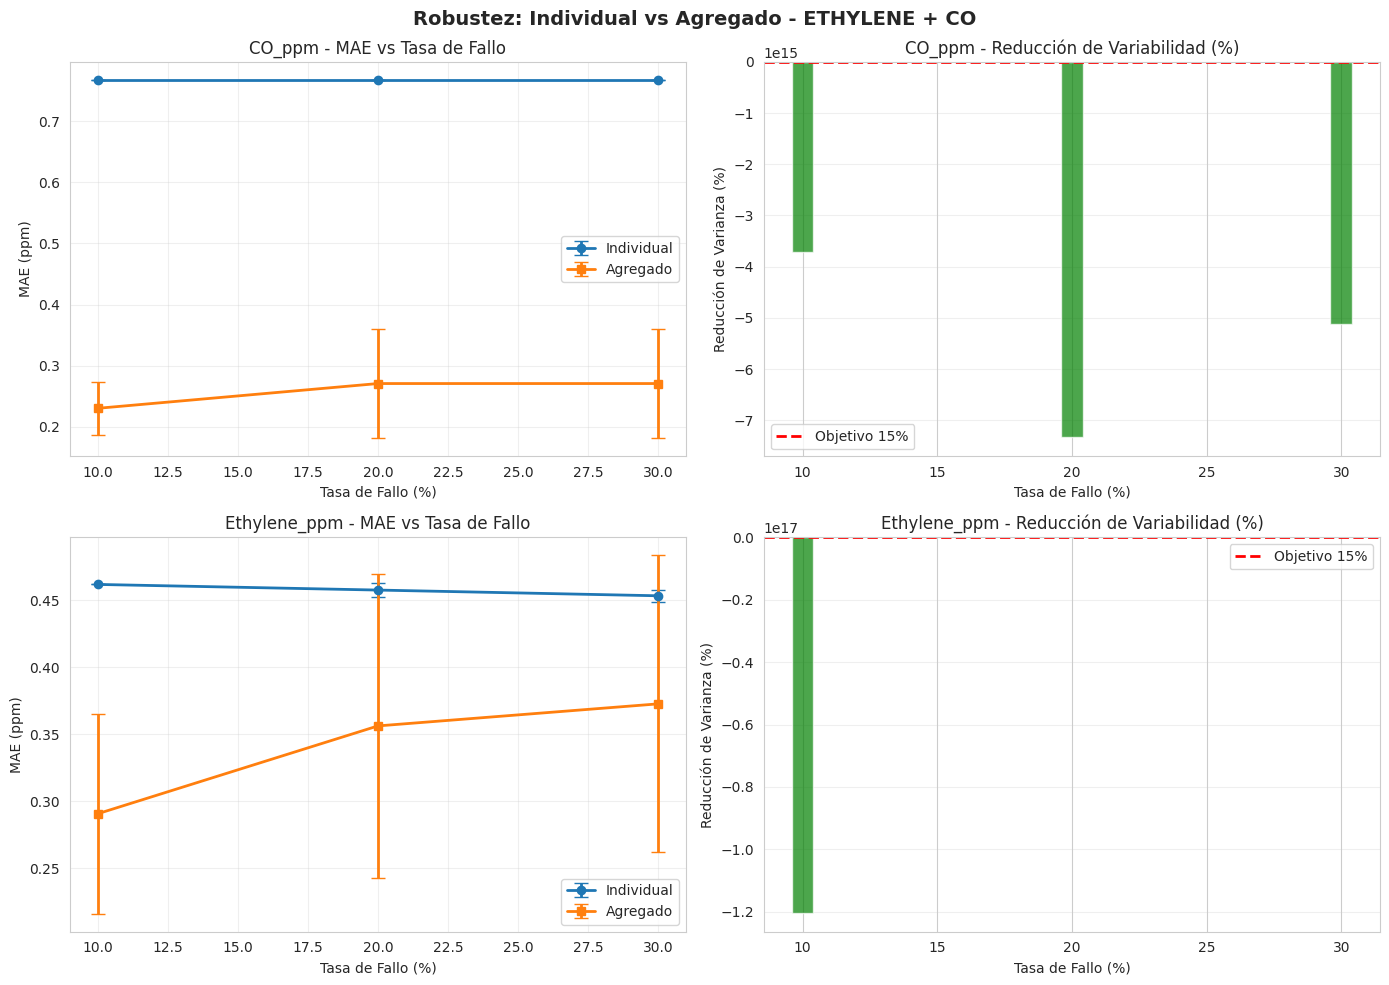


Methane_ppm:
  Reducción de variabilidad promedio: -10668.07%
  Tasa 10%: Reducción = -13640.46%
  Tasa 20%: Reducción = -9866.19%
  Tasa 30%: Reducción = -8497.55%

Ethylene_ppm:
  Reducción de variabilidad promedio: -358.12%
  Tasa 10%: Reducción = -308.59%
  Tasa 20%: Reducción = -400.87%
  Tasa 30%: Reducción = -364.90%


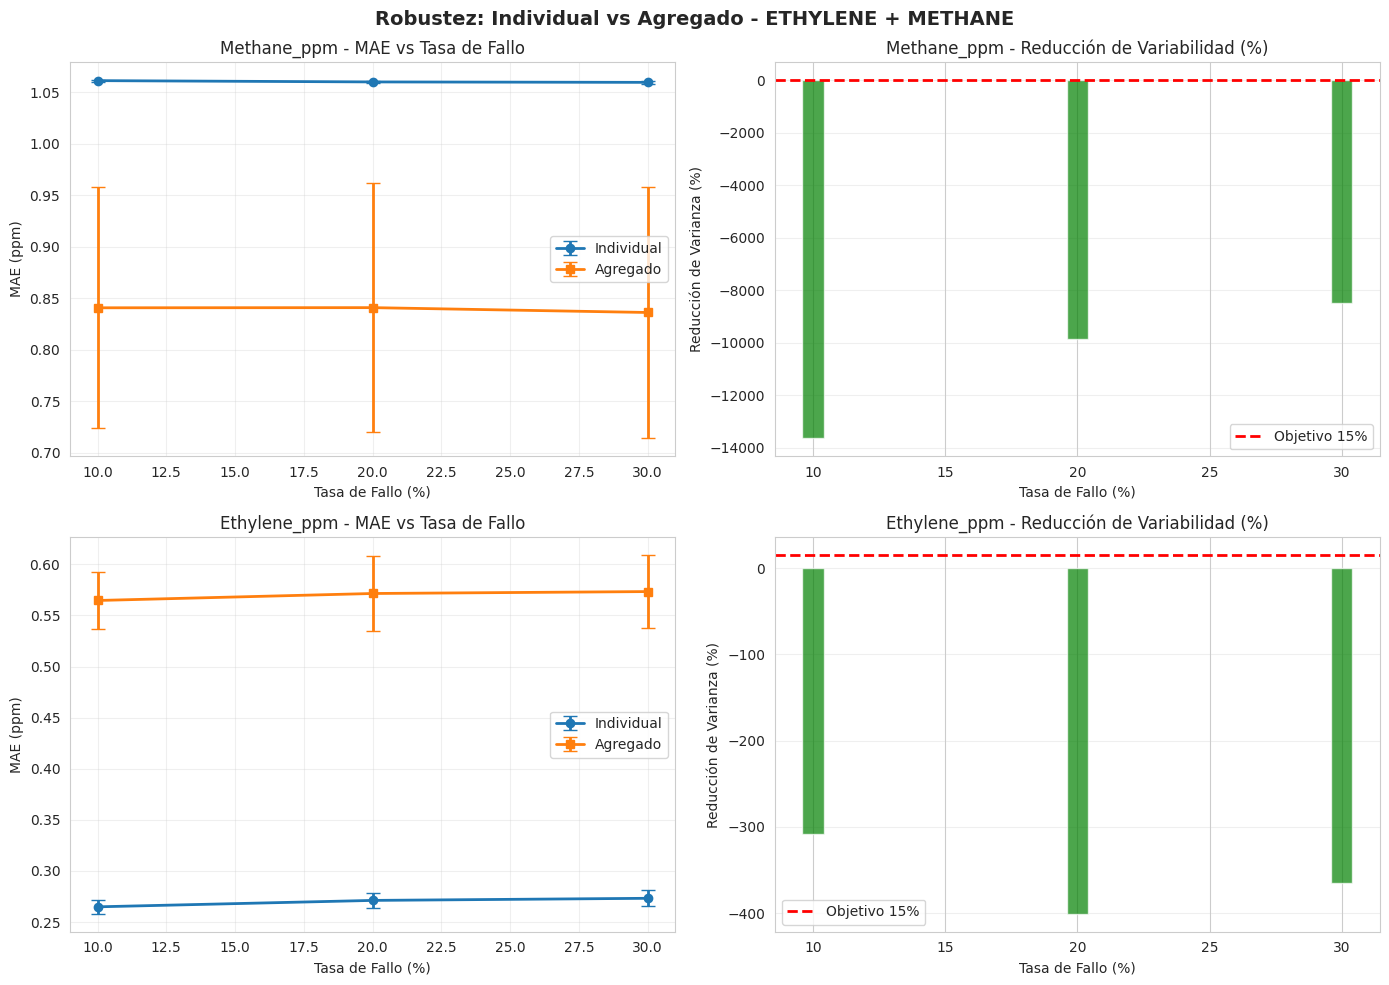

In [51]:
# Celda 56: Comparación de robustez: Individual vs Agregado
print("=" * 70)
print("COMPARACIÓN DE ROBUSTEZ: INDIVIDUAL VS AGREGADO")
print("=" * 70)

def compare_robustness_individual_vs_aggregated(results_ind, results_agg, target_cols, dataset_name):
    """
    Compara la robustez entre modelos individuales y agregados
    """
    fig, axes = plt.subplots(len(target_cols), 2, figsize=(14, 10))
    
    if len(target_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, target in enumerate(target_cols):
        # Agrupar resultados
        grouped_ind = results_ind.groupby('failure_rate')
        grouped_agg = results_agg.groupby('failure_rate')
        
        failure_rates_ind = []
        mae_means_ind = []
        mae_stds_ind = []
        
        failure_rates_agg = []
        mae_means_agg = []
        mae_stds_agg = []
        
        for rate, group in grouped_ind:
            failure_rates_ind.append(rate * 100)
            mae_means_ind.append(group[f'{target}_MAE'].mean())
            mae_stds_ind.append(group[f'{target}_MAE'].std())
        
        for rate, group in grouped_agg:
            failure_rates_agg.append(rate * 100)
            mae_means_agg.append(group[f'{target}_MAE'].mean())
            mae_stds_agg.append(group[f'{target}_MAE'].std())
        
        # Plot MAE
        axes[idx, 0].errorbar(failure_rates_ind, mae_means_ind, yerr=mae_stds_ind, 
                              marker='o', capsize=5, linewidth=2, label='Individual')
        axes[idx, 0].errorbar(failure_rates_agg, mae_means_agg, yerr=mae_stds_agg, 
                              marker='s', capsize=5, linewidth=2, label='Agregado')
        axes[idx, 0].set_title(f'{target} - MAE vs Tasa de Fallo')
        axes[idx, 0].set_xlabel('Tasa de Fallo (%)')
        axes[idx, 0].set_ylabel('MAE (ppm)')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Calcular reducción de variabilidad
        variance_reduction = []
        for i in range(len(mae_stds_ind)):
            if mae_stds_ind[i] > 0:
                reduction = ((mae_stds_ind[i] - mae_stds_agg[i]) / mae_stds_ind[i]) * 100
                variance_reduction.append(reduction)
            else:
                variance_reduction.append(0)
        
        axes[idx, 1].bar(failure_rates_ind, variance_reduction, alpha=0.7, color='green')
        axes[idx, 1].set_title(f'{target} - Reducción de Variabilidad (%)')
        axes[idx, 1].set_xlabel('Tasa de Fallo (%)')
        axes[idx, 1].set_ylabel('Reducción de Varianza (%)')
        axes[idx, 1].axhline(y=15, color='red', linestyle='--', linewidth=2, label='Objetivo 15%')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3, axis='y')
        
        # Imprimir resultados
        print(f"\n{target}:")
        print(f"  Reducción de variabilidad promedio: {np.mean(variance_reduction):.2f}%")
        for i, rate in enumerate(failure_rates_ind):
            print(f"  Tasa {rate:.0f}%: Reducción = {variance_reduction[i]:.2f}%")
    
    plt.suptitle(f'Robustez: Individual vs Agregado - {dataset_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Comparar robustez
compare_robustness_individual_vs_aggregated(results_robustness_co, results_agg_robustness_co, 
                                             targets_co, 'ETHYLENE + CO')
compare_robustness_individual_vs_aggregated(results_robustness_methane, results_agg_robustness_methane, 
                                             targets_methane, 'ETHYLENE + METHANE')